,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low
1993-01-29,28.328257,28.328257,28.187352,43.937500,1.557081e+06,28.308155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,28.328257,28.509494,28.328257,44.250000,7.457910e+05,28.509494,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.308155,NaN,NaN,NaN,NaN,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.187352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-02,28.489328,28.590029,28.428958,44.343700,3.124407e+05,28.569863,28.328257,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.509494,28.308155,NaN,NaN,NaN,28.509494,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.328257,28.187352,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-03,28.610130,28.892004,28.590028,44.812500,8.216895e+05,28.871902,28.489328,28.328257,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,28.569863,28.509494,28.308155,NaN,NaN,28.590029,28.509494,28.328257,NaN,NaN,NaN,NaN,NaN,NaN,28.428958,28.328257,28.187352,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-04,28.972539,29.053074,28.650398,45.000000,8.249489e+05,28.992705,28.610130,28.489328,28.328257,28.328257,NaN,NaN,NaN,NaN,NaN,28.871902,28.569863,28.509494,28.308155,NaN,28.892004,28.590029,28.509494,28.328257,NaN,NaN,NaN,NaN,NaN,28.590028,28.428958,28.328257,28.187352,NaN,NaN,NaN,NaN,NaN
1993-02-05,28.972540,29.032974,28.811469,44.968700,7.637956e+05,28.972540,28.972539,28.610130,28.489328,28.328257,28.328257,NaN,NaN,NaN,NaN,28.992705,28.871902,28.569863,28.509494,28.308155,29.053074,28.892004,28.590029,28.509494,28.328257,NaN,NaN,NaN,NaN,28.650398,28.590028,28.428958,28.328257,28.187352,NaN,NaN,NaN,NaN
1993-02-08,28.972540,29.073241,28.932272,44.968700,9.252155e+05,28.972540,28.972540,28.972539,28.610130,28.489328,28.328257,NaN,NaN,NaN,NaN,28.972540,28.992705,28.871902,28.569863,28.509494,29.032974,29.053074,28.892004,28.590029,28.509494,NaN,NaN,NaN,NaN,28.811469,28.650398,28.590028,28.428958,28.328257,NaN,NaN,NaN,NaN
1993-02-09,28.871902,28.871902,28.710832,44.656200,1.895132e+05,28.771201,28.972540,28.972540,28.972539,28.610130,28.489328,NaN,NaN,NaN,NaN,28.972540,28.972540,28.992705,28.871902,28.569863,29.073241,29.032974,29.053074,28.892004,28.590029,NaN,NaN,NaN,NaN,28.932272,28.811469,28.650398,28.590028,28.428958,NaN,NaN,NaN,NaN
1993-02-10,28.771201,28.831635,28.690666,44.718700,5.891827e+05,28.811469,28.871902,28.972540,28.972540,28.972539,28.610130,NaN,NaN,NaN,NaN,28.771201,28.972540,28.972540,28.992705,28.871902,28.871902,29.073241,29.032974,29.053074,28.892004,NaN,NaN,NaN,NaN,28.710832,28.932272,28.811469,28.650398,28.590028,NaN,NaN,NaN,NaN
1993-02-11,28.851737,29.073241,28.851737,44.937500,3.026623e+04,28.952438,28.771201,28.871902,28.972540,28.972540,28.972539,NaN,NaN,NaN,NaN,28.811469,28.771201,28.972540,28.972540,28.992705,28.831635,28.871902,29.073241,29.032974,29.053074,NaN,NaN,NaN,NaN,28.690666,28.710832,28.932272,28.811469,28.650398,NaN,NaN,NaN,NaN


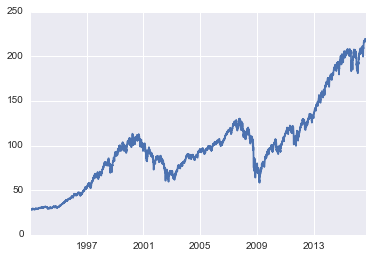

In [5]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import random

pd.set_option('display.max_columns', 50)

dfSPY = pd.read_csv('allSPY.csv', index_col='Date', parse_dates=True, na_values = ['nan'])

del dfSPY.index.name
# display(dfSPY)

start_date = '1993-01-29'
end_date = '2016-09-06'

dates = pd.date_range(start_date, end_date)

dfMain = pd.DataFrame(index=dates)
dfMain = dfMain.join(dfSPY)
dfMain.dropna(inplace=True)

# Adjust Open, High, Low, Volume
dfMain['Adj Factor'] = dfMain['Adj Close'] / dfMain['Close']

dfMain['Open'] = dfMain['Open'] * dfMain['Adj Factor']
dfMain['High'] = dfMain['High'] * dfMain['Adj Factor']
dfMain['Low'] = dfMain['Low'] * dfMain['Adj Factor']

dfMain['Volume'] = dfMain['Volume'] / dfMain['Adj Factor']

dfMain.drop(['Adj Factor'], axis=1, inplace=True)

# Price Engineering
# Get opens
dfMain['-1d_Open'] = dfMain['Open'].shift()
dfMain['-2d_Open'] = dfMain['Open'].shift(2)
dfMain['-3d_Open'] = dfMain['Open'].shift(3)
dfMain['-4d_Open'] = dfMain['Open'].shift(4)
dfMain['-5d_Open'] = dfMain['Open'].shift(5)
dfMain['-10d_Open'] = dfMain['Open'].shift(10)
dfMain['-21d_Open'] = dfMain['Open'].shift(21)
dfMain['-63d_Open'] = dfMain['Open'].shift(63)
dfMain['-100d_Open'] = dfMain['Open'].shift(100)

# Get adjCloses
dfMain['-1d_adjClose'] = dfMain['Adj Close'].shift()
dfMain['-2d_adjClose'] = dfMain['Adj Close'].shift(2)
dfMain['-3d_adjClose'] = dfMain['Adj Close'].shift(3)
dfMain['-4d_adjClose'] = dfMain['Adj Close'].shift(4)
dfMain['-5d_adjClose'] = dfMain['Adj Close'].shift(5)

# Get highs
dfMain['-1d_High'] = dfMain['High'].shift()
dfMain['-2d_High'] = dfMain['High'].shift(2)
dfMain['-3d_High'] = dfMain['High'].shift(3)
dfMain['-4d_High'] = dfMain['High'].shift(4)
dfMain['-5d_High'] = dfMain['High'].shift(5)
dfMain['10d_High'] = dfMain['High'].shift().rolling(window=10).max()
dfMain['21d_High'] = dfMain['High'].shift().rolling(window=21).max()
dfMain['63d_High'] = dfMain['High'].shift().rolling(window=63).max()
dfMain['100d_High'] = dfMain['High'].shift().rolling(window=100).max()

# Get lows
dfMain['-1d_Low'] = dfMain['Low'].shift()
dfMain['-2d_Low'] = dfMain['Low'].shift(2)
dfMain['-3d_Low'] = dfMain['Low'].shift(3)
dfMain['-4d_Low'] = dfMain['Low'].shift(4)
dfMain['-5d_Low'] = dfMain['Low'].shift(5)
dfMain['10d_Low'] = dfMain['Low'].shift().rolling(window=10).min()
dfMain['21d_Low'] = dfMain['Low'].shift().rolling(window=21).min()
dfMain['63d_Low'] = dfMain['Low'].shift().rolling(window=63).min()
dfMain['100d_Low'] = dfMain['Low'].shift().rolling(window=100).min()

plt.plot(dfMain['Adj Close'])
display(dfMain)

In [6]:
dfMain['100d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=100).mean() * 1.5
dfMain['100d_Max_Vol'] = dfMain['Volume'].shift().rolling(window=100).max()

dfMain['Abs_Spread'] = np.abs(dfMain['Close'] - dfMain['Open'])
dfMain['Abs_Spread_Shift1'] = dfMain['Abs_Spread'].shift()

dfMain['100d_Avg_Spread'] = dfMain['Abs_Spread_Shift1'].rolling(window=100).mean() * 1.5
dfMain['100d_Max_Spread'] = dfMain['100d_High'] - dfMain['100d_Low']

dfMain.drop(['Abs_Spread_Shift1', 'Abs_Spread'], axis=1, inplace=True)

display(dfMain.tail(20))

,Open,High,Low,Close,Volume,Adj Close,-1d_Open,-2d_Open,-3d_Open,-4d_Open,-5d_Open,-10d_Open,-21d_Open,-63d_Open,-100d_Open,-1d_adjClose,-2d_adjClose,-3d_adjClose,-4d_adjClose,-5d_adjClose,-1d_High,-2d_High,-3d_High,-4d_High,-5d_High,10d_High,21d_High,63d_High,100d_High,-1d_Low,-2d_Low,-3d_Low,-4d_Low,-5d_Low,10d_Low,21d_Low,63d_Low,100d_Low,100d_Avg_Vol,100d_Max_Vol,100d_Avg_Spread,100d_Max_Spread
2016-08-09,218.130005,218.759995,217.800003,218.179993,51251700.0,218.179993,218.399994,216.410004,216.309998,215.479996,216.649994,216.529999,213.190002,205.650534,201.151071,218.050003,218.179993,216.410004,216.179993,215.550003,218.520004,218.229996,216.779999,216.250000,216.830002,218.520004,218.520004,218.520004,218.520004,217.740005,216.410004,214.250000,215.130005,214.570007,214.250000,212.949997,198.649994,198.649994,1.403559e+08,333444400.0,1.742677,19.870010
2016-08-10,218.309998,218.399994,217.229996,217.639999,57941100.0,217.639999,218.130005,218.399994,216.410004,216.309998,215.479996,217.190002,214.529999,206.834380,203.113723,218.179993,218.050003,218.179993,216.410004,216.179993,218.759995,218.520004,218.229996,216.779999,216.250000,218.759995,218.759995,218.759995,218.759995,217.800003,217.740005,216.410004,214.250000,215.130005,214.250000,213.429993,198.649994,198.649994,1.390896e+08,333444400.0,1.691243,20.110001
2016-08-11,218.259995,218.940002,217.949997,218.649994,72504300.0,218.649994,218.309998,218.130005,218.399994,216.410004,216.309998,216.289993,215.440002,206.217577,203.014250,217.639999,218.179993,218.050003,218.179993,216.410004,218.399994,218.759995,218.520004,218.229996,216.779999,218.759995,218.759995,218.759995,218.759995,217.229996,217.800003,217.740005,216.410004,214.250000,214.250000,214.250000,198.649994,198.649994,1.378723e+08,333444400.0,1.682299,20.110001
2016-08-12,218.289993,218.710007,217.990005,218.460007,61313500.0,218.460007,218.259995,218.309998,218.130005,218.399994,216.410004,216.460007,216.399994,205.143178,202.705842,218.649994,217.639999,218.179993,218.050003,218.179993,218.940002,218.399994,218.759995,218.520004,218.229996,218.940002,218.940002,218.940002,218.940002,217.949997,217.229996,217.800003,217.740005,216.410004,214.250000,214.250000,198.649994,198.649994,1.378603e+08,333444400.0,1.663313,20.290008
2016-08-15,218.889999,219.500000,218.880005,219.089996,49813500.0,219.089996,218.289993,218.259995,218.309998,218.130005,218.399994,217.190002,216.779999,203.899646,203.054037,218.460007,218.649994,217.639999,218.179993,218.050003,218.710007,218.940002,218.399994,218.759995,218.520004,218.940002,218.940002,218.940002,218.940002,217.990005,217.949997,217.229996,217.800003,217.740005,214.250000,214.250000,198.649994,198.649994,1.373103e+08,333444400.0,1.638051,20.290008
2016-08-16,218.600006,218.679993,217.960007,217.960007,53213600.0,217.960007,218.889999,218.289993,218.259995,218.309998,218.130005,216.649994,215.970001,205.391886,200.954952,219.089996,218.460007,218.649994,217.639999,218.179993,219.500000,218.710007,218.940002,218.399994,218.759995,219.500000,219.500000,219.500000,219.500000,218.880005,217.990005,217.949997,217.229996,217.800003,214.250000,214.250000,198.649994,198.649994,1.368354e+08,333444400.0,1.638711,20.850006
2016-08-17,218.000000,218.529999,217.020004,218.369995,75134300.0,218.369995,218.600006,218.889999,218.289993,218.259995,218.309998,215.479996,215.919998,203.382331,202.556624,217.960007,219.089996,218.460007,218.649994,217.639999,218.679993,219.500000,218.710007,218.940002,218.399994,219.500000,219.500000,219.500000,219.500000,217.960007,218.880005,217.990005,217.949997,217.229996,214.250000,214.250000,198.649994,198.649994,1.363616e+08,333444400.0,1.615835,20.850006
2016-08-18,218.339996,218.899994,218.210007,218.860001,52989300.0,218.860001,218.000000,218.600006,218.889999,218.289993,218.259995,216.309998,216.190002,203.004292,201.711015,218.369995,217.960007,219.089996,218.460007,218.649994,218.529999,218.679993,219.500000,218.710007,218.940002,2

In [7]:
def relative_transform(num):
    if 0 <= num < 0.25:
        return 1
    elif 0.25 <= num < 0.5:
        return 2
    elif 0.5 <= num < 0.75:
        return 3
    elif 0.75 <= num < 1:
        return 4
    elif 1 <= num:
        return 5
    elif -0.25 <= num < 0:
        return -1
    elif -0.5 <= num < -0.25:
        return -2
    elif -0.75 <= num < -0.5:
        return -3
    elif -1 <= num < -0.75:
        return -4
    elif num < -1:
        return -5
    else:
        num

# def relative_transform(num):
#     if 0 <= num < 0.25:
#         return "Very Low"
#     elif 0.25 <= num < 0.5:
#         return "Low"
#     elif 0.5 <= num < 0.75:
#         return "Average"
#     elif 0.75 <= num < 1:
#         return "High"
#     elif 1 <= num:
#         return "Very High"
#     elif -0.25 <= num < 0:
#         return "N-Very Low"
#     elif -0.5 <= num < -0.25:
#         return "N-Low"
#     elif -0.75 <= num < -0.5:
#         return "N-Average"
#     elif -1 <= num < -0.75:
#         return "N-High"
#     elif num < -1:
#         return "N-Very High"
#     else:
#         num

# Volume Engineering
# Get volumes
dfMain['-1d_Vol'] = dfMain['Volume'].shift()
dfMain['-2d_Vol'] = dfMain['Volume'].shift(2)
dfMain['-3d_Vol'] = dfMain['Volume'].shift(3)
dfMain['-4d_Vol'] = dfMain['Volume'].shift(4)
dfMain['-5d_Vol'] = dfMain['Volume'].shift(5)

# Get avg. volumes
dfMain['10d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=10).mean()
dfMain['21d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=21).mean()
dfMain['63d_Avg_Vol'] = dfMain['Volume'].shift().rolling(window=63).mean()

# Get relative volumes 1
dfMain['-1d_Vol1'] = dfMain['-1d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-2d_Vol1'] = dfMain['-2d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-3d_Vol1'] = dfMain['-3d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-4d_Vol1'] = dfMain['-4d_Vol'] / dfMain['100d_Avg_Vol']
dfMain['-5d_Vol1'] = dfMain['-5d_Vol'] / dfMain['100d_Avg_Vol']

dfMain['-1d_Vol1'] = dfMain['-1d_Vol1'].apply(relative_transform)
dfMain['-2d_Vol1'] = dfMain['-2d_Vol1'].apply(relative_transform)
dfMain['-3d_Vol1'] = dfMain['-3d_Vol1'].apply(relative_transform)
dfMain['-4d_Vol1'] = dfMain['-4d_Vol1'].apply(relative_transform)
dfMain['-5d_Vol1'] = dfMain['-5d_Vol1'].apply(relative_transform)

# Get relative avg. volumes 1 
dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol'] / dfMain['100d_Avg_Vol']
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol'] / dfMain['100d_Avg_Vol']

dfMain['10d_Avg_Vol1'] = dfMain['10d_Avg_Vol1'].apply(relative_transform)
dfMain['21d_Avg_Vol1'] = dfMain['21d_Avg_Vol1'].apply(relative_transform)
dfMain['63d_Avg_Vol1'] = dfMain['63d_Avg_Vol1'].apply(relative_transform)

# Get relative volumes 2
dfMain['-1d_Vol2'] = dfMain['-1d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-2d_Vol2'] = dfMain['-2d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-3d_Vol2'] = dfMain['-3d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-4d_Vol2'] = dfMain['-4d_Vol'] / dfMain['100d_Max_Vol']
dfMain['-5d_Vol2'] = dfMain['-5d_Vol'] / dfMain['100d_Max_Vol']

dfMain['-1d_Vol2'] = dfMain['-1d_Vol2'].apply(relative_transform)
dfMain['-2d_Vol2'] = dfMain['-2d_Vol2'].apply(relative_transform)
dfMain['-3d_Vol2'] = dfMain['-3d_Vol2'].apply(relative_transform)
dfMain['-4d_Vol2'] = dfMain['-4d_Vol2'].apply(relative_transform)
dfMain['-5d_Vol2'] = dfMain['-5d_Vol2'].apply(relative_transform)

display(dfMain[dfMain['-1d_Vol1'] == 5][['-1d_Vol1', '-1d_Vol2', '-2d_Vol1', '-2d_Vol2', '-3d_Vol1', '-3d_Vol2', '10d_Avg_Vol1']])
                      
# display(dfMain[['-1d_Vol1', '-1d_Vol2', '-2d_Vol1', '-2d_Vol2', '-3d_Vol1', '-3d_Vol2', '10d_Avg_Vol1']].tail(30))

,-1d_Vol1,-1d_Vol2,-2d_Vol1,-2d_Vol2,-3d_Vol1,-3d_Vol2,10d_Avg_Vol1
1993-06-24,5.0,2.0,3.0,1.0,1.0,1.0,3.0
1993-06-25,5.0,2.0,5.0,2.0,3.0,1.0,4.0
1993-06-29,5.0,3.0,1.0,1.0,5.0,2.0,4.0
1993-07-01,5.0,3.0,4.0,2.0,5.0,3.0,4.0
1993-07-02,5.0,4.0,5.0,3.0,4.0,2.0,5.0
1993-07-06,5.0,2.0,5.0,4.0,5.0,3.0,5.0
1993-07-07,5.0,2.0,5.0,2.0,5.0,4.0,5.0
1993-07-08,5.0,3.0,5.0,2.0,5.0,2.0,5.0
1993-07-09,5.0,2.0,5.0,3.0,5.0,2.0,5.0
1993-07-12,5.0,3.0,5.0,2.0,5.0,3.0,5.0


In [8]:
# Spread Engineering
# Get spread

dfMain['-1d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-1d_Open']
dfMain['-2d_Spread'] = dfMain['-2d_adjClose'] - dfMain['-2d_Open']
dfMain['-3d_Spread'] = dfMain['-3d_adjClose'] - dfMain['-3d_Open']
dfMain['-4d_Spread'] = dfMain['-4d_adjClose'] - dfMain['-4d_Open']
dfMain['-5d_Spread'] = dfMain['-5d_adjClose'] - dfMain['-5d_Open']

dfMain['10d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-10d_Open']
dfMain['21d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-21d_Open']
dfMain['63d_Spread'] = dfMain['-1d_adjClose'] - dfMain['-63d_Open']

# Get relative spread
dfMain['-1d_Spread'] = dfMain['-1d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-2d_Spread'] = dfMain['-2d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-3d_Spread'] = dfMain['-3d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-4d_Spread'] = dfMain['-4d_Spread'] / dfMain['100d_Avg_Spread']
dfMain['-5d_Spread'] = dfMain['-5d_Spread'] / dfMain['100d_Avg_Spread']

dfMain['-1d_Spread'] = dfMain['-1d_Spread'].apply(relative_transform)
dfMain['-2d_Spread'] = dfMain['-2d_Spread'].apply(relative_transform)
dfMain['-3d_Spread'] = dfMain['-3d_Spread'].apply(relative_transform)
dfMain['-4d_Spread'] = dfMain['-4d_Spread'].apply(relative_transform)
dfMain['-5d_Spread'] = dfMain['-5d_Spread'].apply(relative_transform)

dfMain['10d_Spread'] = dfMain['10d_Spread'] / dfMain['100d_Max_Spread']
dfMain['21d_Spread'] = dfMain['21d_Spread'] / dfMain['100d_Max_Spread']
dfMain['63d_Spread'] = dfMain['63d_Spread'] / dfMain['100d_Max_Spread']

dfMain['10d_Spread'] = dfMain['10d_Spread'].apply(relative_transform)
dfMain['21d_Spread'] = dfMain['21d_Spread'].apply(relative_transform)
dfMain['63d_Spread'] = dfMain['63d_Spread'].apply(relative_transform)

display(dfMain[['-1d_Spread', '-2d_Spread', '-3d_Spread', '-4d_Spread', '-5d_Spread', '21d_Spread']].tail(100))
# display(dfMain[dfMain['63d_Spread'] < 0]['63d_Spread'])

,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,21d_Spread
2016-04-15,-1.0,2.0,2.0,-2.0,-1.0,2.0
2016-04-18,-1.0,-1.0,2.0,2.0,-2.0,1.0
2016-04-19,2.0,-1.0,-1.0,2.0,2.0,1.0
2016-04-20,1.0,2.0,-1.0,-1.0,2.0,1.0
2016-04-21,1.0,1.0,2.0,-1.0,-1.0,1.0
2016-04-22,-2.0,1.0,1.0,2.0,-1.0,1.0
2016-04-25,1.0,-2.0,1.0,1.0,2.0,1.0
2016-04-26,1.0,1.0,-2.0,1.0,1.0,1.0
2016-04-27,-1.0,1.0,1.0,-2.0,1.0,1.0
2016-04-28,2.0,-1.0,1.0,1.0,-2.0,1.0


In [9]:
# Get wicks
def upperwick(open, adj_close, high):
    if high > open and high > adj_close:
        return True
    else:
        return False
def lowerwick(open, adj_close, low):
    if low < open and low < adj_close:
        return True
    else:
        return False
    
for index, row in dfMain.iterrows():
    dfMain.ix[index, '-1d_upperwick_bool'] = upperwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_High'])
    dfMain.ix[index, '-1d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-1d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '-1d_Low'])
    
    dfMain.ix[index, '-2d_upperwick_bool'] = upperwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_High'])
    dfMain.ix[index, '-2d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-2d_Open'], dfMain.ix[index, '-2d_adjClose'], dfMain.ix[index, '-2d_Low'])
    
    dfMain.ix[index, '-3d_upperwick_bool'] = upperwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_High'])
    dfMain.ix[index, '-3d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-3d_Open'], dfMain.ix[index, '-3d_adjClose'], dfMain.ix[index, '-3d_Low'])
    
    dfMain.ix[index, '-4d_upperwick_bool'] = upperwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_High'])
    dfMain.ix[index, '-4d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-4d_Open'], dfMain.ix[index, '-4d_adjClose'], dfMain.ix[index, '-4d_Low'])
    
    dfMain.ix[index, '-5d_upperwick_bool'] = upperwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_High'])
    dfMain.ix[index, '-5d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-5d_Open'], dfMain.ix[index, '-5d_adjClose'], dfMain.ix[index, '-5d_Low'])
    
    dfMain.ix[index, '10d_upperwick_bool'] = upperwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_High'])
    dfMain.ix[index, '10d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-10d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '10d_Low'])
    
    dfMain.ix[index, '21d_upperwick_bool'] = upperwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_High'])
    dfMain.ix[index, '21d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-21d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '21d_Low'])
    
    dfMain.ix[index, '63d_upperwick_bool'] = upperwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_High'])
    dfMain.ix[index, '63d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-63d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '63d_Low'])
    
    dfMain.ix[index, '100d_upperwick_bool'] = upperwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_High'])
    dfMain.ix[index, '100d_lowerwick_bool'] = lowerwick(dfMain.ix[index, '-100d_Open'], dfMain.ix[index, '-1d_adjClose'], dfMain.ix[index, '100d_Low'])
    
# print(dfMain.head(20))

In [10]:
# Transform upper wicks
p_spread1d_up = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_upperwick_bool']
n_spread1d_up = dfMain['-1d_Spread'] < 0 & dfMain['-1d_upperwick_bool']
p_spread2d_up = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_upperwick_bool']
n_spread2d_up = dfMain['-2d_Spread'] < 0 & dfMain['-2d_upperwick_bool']
p_spread3d_up = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_upperwick_bool']
n_spread3d_up = dfMain['-3d_Spread'] < 0 & dfMain['-3d_upperwick_bool']
p_spread4d_up = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_upperwick_bool']
n_spread4d_up = dfMain['-4d_Spread'] < 0 & dfMain['-4d_upperwick_bool']
p_spread5d_up = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_upperwick_bool']
n_spread5d_up = dfMain['-5d_Spread'] < 0 & dfMain['-5d_upperwick_bool']
p_spread10d_up = dfMain['10d_Spread'] >= 0 & dfMain['10d_upperwick_bool']
n_spread10d_up = dfMain['10d_Spread'] < 0 & dfMain['10d_upperwick_bool']
p_spread21d_up = dfMain['21d_Spread'] >= 0 & dfMain['21d_upperwick_bool']
n_spread21d_up = dfMain['21d_Spread'] < 0 & dfMain['21d_upperwick_bool']
p_spread63d_up = dfMain['63d_Spread'] >= 0 & dfMain['63d_upperwick_bool']
n_spread63d_up = dfMain['63d_Spread'] < 0 & dfMain['63d_upperwick_bool']

false1d_up = np.logical_not(dfMain['-1d_upperwick_bool'])
false2d_up = np.logical_not(dfMain['-2d_upperwick_bool'])
false3d_up = np.logical_not(dfMain['-3d_upperwick_bool'])
false4d_up = np.logical_not(dfMain['-4d_upperwick_bool'])
false5d_up = np.logical_not(dfMain['-5d_upperwick_bool'])
false10d_up = np.logical_not(dfMain['10d_upperwick_bool'])
false21d_up = np.logical_not(dfMain['21d_upperwick_bool'])
false63d_up = np.logical_not(dfMain['63d_upperwick_bool'])

dfMain.loc[p_spread1d_up, '-1d_upperwick'] = dfMain.loc[p_spread1d_up, '-1d_High'] - dfMain.loc[p_spread1d_up, '-1d_adjClose']
dfMain.loc[n_spread1d_up, '-1d_upperwick'] = dfMain.loc[n_spread1d_up, '-1d_High'] - dfMain.loc[n_spread1d_up, '-1d_Open']

dfMain.loc[p_spread2d_up, '-2d_upperwick'] = dfMain.loc[p_spread2d_up, '-2d_High'] - dfMain.loc[p_spread2d_up, '-2d_adjClose']
dfMain.loc[n_spread2d_up, '-2d_upperwick'] = dfMain.loc[n_spread2d_up, '-2d_High'] - dfMain.loc[n_spread2d_up, '-2d_Open']

dfMain.loc[p_spread3d_up, '-3d_upperwick'] = dfMain.loc[p_spread3d_up, '-3d_High'] - dfMain.loc[p_spread3d_up, '-3d_adjClose']
dfMain.loc[n_spread3d_up, '-3d_upperwick'] = dfMain.loc[n_spread3d_up, '-3d_High'] - dfMain.loc[n_spread3d_up, '-3d_Open']

dfMain.loc[p_spread4d_up, '-4d_upperwick'] = dfMain.loc[p_spread4d_up, '-4d_High'] - dfMain.loc[p_spread4d_up, '-4d_adjClose']
dfMain.loc[n_spread4d_up, '-4d_upperwick'] = dfMain.loc[n_spread4d_up, '-4d_High'] - dfMain.loc[n_spread4d_up, '-4d_Open']

dfMain.loc[p_spread5d_up, '-5d_upperwick'] = dfMain.loc[p_spread5d_up, '-5d_High'] - dfMain.loc[p_spread5d_up, '-5d_adjClose']
dfMain.loc[n_spread5d_up, '-5d_upperwick'] = dfMain.loc[n_spread5d_up, '-5d_High'] - dfMain.loc[n_spread5d_up, '-5d_Open']

dfMain.loc[p_spread10d_up, '10d_upperwick'] = dfMain.loc[p_spread10d_up, '10d_High'] - dfMain.loc[p_spread10d_up, '-1d_adjClose']
dfMain.loc[n_spread10d_up, '10d_upperwick'] = dfMain.loc[n_spread10d_up, '10d_High'] - dfMain.loc[n_spread10d_up, '-10d_Open']

dfMain.loc[p_spread21d_up, '21d_upperwick'] = dfMain.loc[p_spread21d_up, '21d_High'] - dfMain.loc[p_spread21d_up, '-1d_adjClose']
dfMain.loc[n_spread21d_up, '21d_upperwick'] = dfMain.loc[n_spread21d_up, '21d_High'] - dfMain.loc[n_spread21d_up, '-21d_Open']

dfMain.loc[p_spread63d_up, '63d_upperwick'] = dfMain.loc[p_spread63d_up, '63d_High'] - dfMain.loc[p_spread63d_up, '-1d_adjClose']
dfMain.loc[n_spread63d_up, '63d_upperwick'] = dfMain.loc[n_spread63d_up, '63d_High'] - dfMain.loc[n_spread63d_up, '-63d_Open']

dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] / dfMain.loc[dfMain['-1d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] / dfMain.loc[dfMain['-2d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] / dfMain.loc[dfMain['-3d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] / dfMain.loc[dfMain['-4d_upperwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] / dfMain.loc[dfMain['-5d_upperwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] / dfMain.loc[dfMain['10d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] / dfMain.loc[dfMain['21d_upperwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] / dfMain.loc[dfMain['63d_upperwick_bool'], '100d_Max_Spread']

dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'] = dfMain.loc[dfMain['-1d_upperwick_bool'], '-1d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'] = dfMain.loc[dfMain['-2d_upperwick_bool'], '-2d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'] = dfMain.loc[dfMain['-3d_upperwick_bool'], '-3d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'] = dfMain.loc[dfMain['-4d_upperwick_bool'], '-4d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'] = dfMain.loc[dfMain['-5d_upperwick_bool'], '-5d_upperwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'] = dfMain.loc[dfMain['10d_upperwick_bool'], '10d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'] = dfMain.loc[dfMain['21d_upperwick_bool'], '21d_upperwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'] = dfMain.loc[dfMain['63d_upperwick_bool'], '63d_upperwick'].apply(relative_transform)

dfMain.loc[false1d_up, '-1d_upperwick'] = 0
dfMain.loc[false2d_up, '-2d_upperwick'] = 0
dfMain.loc[false3d_up, '-3d_upperwick'] = 0
dfMain.loc[false4d_up, '-4d_upperwick'] = 0
dfMain.loc[false5d_up, '-5d_upperwick'] = 0
dfMain.loc[false10d_up, '10d_upperwick'] = 0
dfMain.loc[false21d_up, '21d_upperwick'] = 0
dfMain.loc[false63d_up, '63d_upperwick'] = 0

In [11]:
display(dfMain[['-1d_upperwick', '-2d_upperwick', '-3d_upperwick', '-4d_upperwick', '-5d_upperwick', '10d_upperwick', '21d_upperwick', '63d_upperwick']].isnull().sum())


-1d_upperwick    56
-2d_upperwick    56
-3d_upperwick    56
-4d_upperwick    56
-5d_upperwick    56
10d_upperwick    82
21d_upperwick    75
63d_upperwick    37
dtype: int64

In [12]:
# Transform lower wicks
p_spread1d_lw = dfMain['-1d_Spread'] >= 0 & dfMain['-1d_lowerwick_bool']
n_spread1d_lw = dfMain['-1d_Spread'] < 0 & dfMain['-1d_lowerwick_bool']
p_spread2d_lw = dfMain['-2d_Spread'] >= 0 & dfMain['-2d_lowerwick_bool']
n_spread2d_lw = dfMain['-2d_Spread'] < 0 & dfMain['-2d_lowerwick_bool']
p_spread3d_lw = dfMain['-3d_Spread'] >= 0 & dfMain['-3d_lowerwick_bool']
n_spread3d_lw = dfMain['-3d_Spread'] < 0 & dfMain['-3d_lowerwick_bool']
p_spread4d_lw = dfMain['-4d_Spread'] >= 0 & dfMain['-4d_lowerwick_bool']
n_spread4d_lw = dfMain['-4d_Spread'] < 0 & dfMain['-4d_lowerwick_bool']
p_spread5d_lw = dfMain['-5d_Spread'] >= 0 & dfMain['-5d_lowerwick_bool']
n_spread5d_lw = dfMain['-5d_Spread'] < 0 & dfMain['-5d_lowerwick_bool']
p_spread10d_lw = dfMain['10d_Spread'] >= 0 & dfMain['10d_lowerwick_bool']
n_spread10d_lw = dfMain['10d_Spread'] < 0 & dfMain['10d_lowerwick_bool']
p_spread21d_lw = dfMain['21d_Spread'] >= 0 & dfMain['21d_lowerwick_bool']
n_spread21d_lw = dfMain['21d_Spread'] < 0 & dfMain['21d_lowerwick_bool']
p_spread63d_lw = dfMain['63d_Spread'] >= 0 & dfMain['63d_lowerwick_bool']
n_spread63d_lw = dfMain['63d_Spread'] < 0 & dfMain['63d_lowerwick_bool']

false1d_lw = np.logical_not(dfMain['-1d_lowerwick_bool'])
false2d_lw = np.logical_not(dfMain['-2d_lowerwick_bool'])
false3d_lw = np.logical_not(dfMain['-3d_lowerwick_bool'])
false4d_lw = np.logical_not(dfMain['-4d_lowerwick_bool'])
false5d_lw = np.logical_not(dfMain['-5d_lowerwick_bool'])
false10d_lw = np.logical_not(dfMain['10d_lowerwick_bool'])
false21d_lw = np.logical_not(dfMain['21d_lowerwick_bool'])
false63d_lw = np.logical_not(dfMain['63d_lowerwick_bool'])

dfMain.loc[p_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[p_spread1d_lw, '-1d_Open'] - dfMain.loc[p_spread1d_lw, '-1d_Low']
dfMain.loc[n_spread1d_lw, '-1d_lowerwick'] = dfMain.loc[n_spread1d_lw, '-1d_adjClose'] - dfMain.loc[n_spread1d_lw, '-1d_Low']

dfMain.loc[p_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[p_spread2d_lw, '-2d_Open'] - dfMain.loc[p_spread2d_lw, '-2d_Low']
dfMain.loc[n_spread2d_lw, '-2d_lowerwick'] = dfMain.loc[n_spread2d_lw, '-2d_adjClose'] - dfMain.loc[n_spread2d_lw, '-2d_Low']

dfMain.loc[p_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[p_spread3d_lw, '-3d_Open'] - dfMain.loc[p_spread3d_lw, '-3d_Low']
dfMain.loc[n_spread3d_lw, '-3d_lowerwick'] = dfMain.loc[n_spread3d_lw, '-3d_adjClose'] - dfMain.loc[n_spread3d_lw, '-3d_Low']

dfMain.loc[p_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[p_spread4d_lw, '-4d_Open'] - dfMain.loc[p_spread4d_lw, '-4d_Low']
dfMain.loc[n_spread4d_lw, '-4d_lowerwick'] = dfMain.loc[n_spread4d_lw, '-4d_adjClose'] - dfMain.loc[n_spread4d_lw, '-4d_Low']

dfMain.loc[p_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[p_spread5d_lw, '-5d_Open'] - dfMain.loc[p_spread5d_lw, '-5d_Low']
dfMain.loc[n_spread5d_lw, '-5d_lowerwick'] = dfMain.loc[n_spread5d_lw, '-5d_adjClose'] - dfMain.loc[n_spread5d_lw, '-5d_Low']

dfMain.loc[p_spread10d_lw, '10d_lowerwick'] = dfMain.loc[p_spread10d_lw, '-10d_Open'] - dfMain.loc[p_spread10d_lw, '10d_Low']
dfMain.loc[n_spread10d_lw, '10d_lowerwick'] = dfMain.loc[n_spread10d_lw, '-1d_adjClose'] - dfMain.loc[n_spread10d_lw, '10d_Low']

dfMain.loc[p_spread21d_lw, '21d_lowerwick'] = dfMain.loc[p_spread21d_lw, '-21d_Open'] - dfMain.loc[p_spread21d_lw, '21d_Low']
dfMain.loc[n_spread21d_lw, '21d_lowerwick'] = dfMain.loc[n_spread21d_lw, '-1d_adjClose'] - dfMain.loc[n_spread21d_lw, '21d_Low']

dfMain.loc[p_spread63d_lw, '63d_lowerwick'] = dfMain.loc[p_spread63d_lw, '-63d_Open'] - dfMain.loc[p_spread63d_lw, '63d_Low']
dfMain.loc[n_spread63d_lw, '63d_lowerwick'] = dfMain.loc[n_spread63d_lw, '-1d_adjClose'] - dfMain.loc[n_spread63d_lw, '63d_Low']

dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] / dfMain.loc[dfMain['-1d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] / dfMain.loc[dfMain['-2d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] / dfMain.loc[dfMain['-3d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] / dfMain.loc[dfMain['-4d_lowerwick_bool'], '100d_Avg_Spread']
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] / dfMain.loc[dfMain['-5d_lowerwick_bool'], '100d_Avg_Spread']

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] / dfMain.loc[dfMain['10d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] / dfMain.loc[dfMain['21d_lowerwick_bool'], '100d_Max_Spread']
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] / dfMain.loc[dfMain['63d_lowerwick_bool'], '100d_Max_Spread']

dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'] = dfMain.loc[dfMain['-1d_lowerwick_bool'], '-1d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'] = dfMain.loc[dfMain['-2d_lowerwick_bool'], '-2d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'] = dfMain.loc[dfMain['-3d_lowerwick_bool'], '-3d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'] = dfMain.loc[dfMain['-4d_lowerwick_bool'], '-4d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'] = dfMain.loc[dfMain['-5d_lowerwick_bool'], '-5d_lowerwick'].apply(relative_transform)

dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'] = dfMain.loc[dfMain['10d_lowerwick_bool'], '10d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'] = dfMain.loc[dfMain['21d_lowerwick_bool'], '21d_lowerwick'].apply(relative_transform)
dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'] = dfMain.loc[dfMain['63d_lowerwick_bool'], '63d_lowerwick'].apply(relative_transform)

dfMain.loc[false1d_lw, '-1d_lowerwick'] = 0
dfMain.loc[false2d_lw, '-2d_lowerwick'] = 0
dfMain.loc[false3d_lw, '-3d_lowerwick'] = 0
dfMain.loc[false4d_lw, '-4d_lowerwick'] = 0
dfMain.loc[false5d_lw, '-5d_lowerwick'] = 0
dfMain.loc[false10d_lw, '10d_lowerwick'] = 0
dfMain.loc[false21d_lw, '21d_lowerwick'] = 0
dfMain.loc[false63d_lw, '63d_lowerwick'] = 0

In [13]:
# dfMain.dropna(inplace=True)
display(dfMain[['-1d_lowerwick', '-2d_lowerwick', '-3d_lowerwick', '-4d_lowerwick', '-5d_lowerwick', '10d_lowerwick', '21d_lowerwick', '63d_lowerwick']].isnull().sum())

-1d_lowerwick    74
-2d_lowerwick    73
-3d_lowerwick    73
-4d_lowerwick    72
-5d_lowerwick    71
10d_lowerwick    83
21d_lowerwick    75
63d_lowerwick    37
dtype: int64

In [14]:
print(dfMain.tail(20))

                  Open        High         Low       Close       Volume  \
2016-08-09  218.130005  218.759995  217.800003  218.179993   51251700.0   
2016-08-10  218.309998  218.399994  217.229996  217.639999   57941100.0   
2016-08-11  218.259995  218.940002  217.949997  218.649994   72504300.0   
2016-08-12  218.289993  218.710007  217.990005  218.460007   61313500.0   
2016-08-15  218.889999  219.500000  218.880005  219.089996   49813500.0   
2016-08-16  218.600006  218.679993  217.960007  217.960007   53213600.0   
2016-08-17  218.000000  218.529999  217.020004  218.369995   75134300.0   
2016-08-18  218.339996  218.899994  218.210007  218.860001   52989300.0   
2016-08-19  218.309998  218.750000  217.740005  218.539993   75443000.0   
2016-08-22  218.259995  218.800003  217.830002  218.529999   61368800.0   
2016-08-23  219.250000  219.600006  218.899994  218.970001   53399200.0   
2016-08-24  218.800003  218.910004  217.360001  217.850006   71728900.0   
2016-08-25  217.399994  2

In [15]:
dfMain['Trade Price'] = dfMain['Open'] * 0.3 + dfMain['Adj Close'] * 0.7
print(dfMain[['Trade Price', 'Open', 'Adj Close']].head())

            Trade Price       Open  Adj Close
1993-01-29    28.314185  28.328257  28.308155
1993-02-01    28.455123  28.328257  28.509494
1993-02-02    28.545702  28.489328  28.569863
1993-02-03    28.793370  28.610130  28.871902
1993-02-04    28.986655  28.972539  28.992705


In [16]:
display(dfMain.columns)

Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Adj Close',
       u'-1d_Open', u'-2d_Open', u'-3d_Open', u'-4d_Open',
       ...
       u'63d_upperwick', u'-1d_lowerwick', u'-2d_lowerwick', u'-3d_lowerwick',
       u'-4d_lowerwick', u'-5d_lowerwick', u'10d_lowerwick', u'21d_lowerwick',
       u'63d_lowerwick', u'Trade Price'],
      dtype='object', length=106)

In [17]:
dfMain.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', \
             '-1d_Vol', '-2d_Vol', '-3d_Vol', '-4d_Vol', '-5d_Vol', '10d_Avg_Vol', '21d_Avg_Vol', '63d_Avg_Vol', \
             '-1d_Open', '-2d_Open', '-3d_Open', '-4d_Open', '-5d_Open', '-10d_Open', '-21d_Open', '-63d_Open', '-100d_Open',  \
             '-1d_adjClose', '-2d_adjClose', '-3d_adjClose', '-4d_adjClose', '-5d_adjClose', \
             '-1d_High', '-2d_High', '-3d_High', '-4d_High', '-5d_High', '10d_High', '21d_High', '63d_High', '100d_High',  \
             '-1d_Low', '-2d_Low', '-3d_Low', '-4d_Low', '-5d_Low', '10d_Low', '21d_Low', '63d_Low', '100d_Low',  \
             '100d_Avg_Vol', '100d_Max_Vol', '100d_Avg_Spread', '100d_Max_Spread', \
             '-1d_upperwick_bool', '-2d_upperwick_bool', '-3d_upperwick_bool', '-4d_upperwick_bool', '-5d_upperwick_bool', '10d_upperwick_bool', '21d_upperwick_bool', '63d_upperwick_bool', '100d_upperwick_bool', \
             '-1d_lowerwick_bool', '-2d_lowerwick_bool', '-3d_lowerwick_bool', '-4d_lowerwick_bool', '-5d_lowerwick_bool', '10d_lowerwick_bool', '21d_lowerwick_bool', '63d_lowerwick_bool', '100d_lowerwick_bool'], \
            axis=1, inplace=True)

In [18]:
display(dfMain.columns)
dfMain.ix[:,:-1]

Index([u'-1d_Vol1', u'-2d_Vol1', u'-3d_Vol1', u'-4d_Vol1', u'-5d_Vol1',
       u'10d_Avg_Vol1', u'21d_Avg_Vol1', u'63d_Avg_Vol1', u'-1d_Vol2',
       u'-2d_Vol2', u'-3d_Vol2', u'-4d_Vol2', u'-5d_Vol2', u'-1d_Spread',
       u'-2d_Spread', u'-3d_Spread', u'-4d_Spread', u'-5d_Spread',
       u'10d_Spread', u'21d_Spread', u'63d_Spread', u'-1d_upperwick',
       u'-2d_upperwick', u'-3d_upperwick', u'-4d_upperwick', u'-5d_upperwick',
       u'10d_upperwick', u'21d_upperwick', u'63d_upperwick', u'-1d_lowerwick',
       u'-2d_lowerwick', u'-3d_lowerwick', u'-4d_lowerwick', u'-5d_lowerwick',
       u'10d_lowerwick', u'21d_lowerwick', u'63d_lowerwick', u'Trade Price'],
      dtype='object')

,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0
1993-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0
1993-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
1993-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [19]:
dfMain.dropna(inplace=True)
# dfMain[dfMain.columns[:-1]] = dfMain[dfMain.columns[:-1]].apply(int)
# display(dfMain[dfMain.columns[:-1]].describe())

print(dfMain.isnull().sum())

# for i in range(37):
#     dfMain[dfMain.columns[i]] = dfMain[dfMain.columns[i]].apply(int)
display(dfMain)

-1d_Vol1         0
-2d_Vol1         0
-3d_Vol1         0
-4d_Vol1         0
-5d_Vol1         0
10d_Avg_Vol1     0
21d_Avg_Vol1     0
63d_Avg_Vol1     0
-1d_Vol2         0
-2d_Vol2         0
-3d_Vol2         0
-4d_Vol2         0
-5d_Vol2         0
-1d_Spread       0
-2d_Spread       0
-3d_Spread       0
-4d_Spread       0
-5d_Spread       0
10d_Spread       0
21d_Spread       0
63d_Spread       0
-1d_upperwick    0
-2d_upperwick    0
-3d_upperwick    0
-4d_upperwick    0
-5d_upperwick    0
10d_upperwick    0
21d_upperwick    0
63d_upperwick    0
-1d_lowerwick    0
-2d_lowerwick    0
-3d_lowerwick    0
-4d_lowerwick    0
-5d_lowerwick    0
10d_lowerwick    0
21d_lowerwick    0
63d_lowerwick    0
Trade Price      0
dtype: int64


,-1d_Vol1,-2d_Vol1,-3d_Vol1,-4d_Vol1,-5d_Vol1,10d_Avg_Vol1,21d_Avg_Vol1,63d_Avg_Vol1,-1d_Vol2,-2d_Vol2,-3d_Vol2,-4d_Vol2,-5d_Vol2,-1d_Spread,-2d_Spread,-3d_Spread,-4d_Spread,-5d_Spread,10d_Spread,21d_Spread,63d_Spread,-1d_upperwick,-2d_upperwick,-3d_upperwick,-4d_upperwick,-5d_upperwick,10d_upperwick,21d_upperwick,63d_upperwick,-1d_lowerwick,-2d_lowerwick,-3d_lowerwick,-4d_lowerwick,-5d_lowerwick,10d_lowerwick,21d_lowerwick,63d_lowerwick,Trade Price
1993-06-23,3.0,1.0,1.0,1.0,5.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,2.0,28.906204
1993-06-24,5.0,3.0,1.0,2.0,1.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,29.122163
1993-06-25,5.0,5.0,3.0,1.0,2.0,4.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,3.0,29.193443
1993-06-28,1.0,5.0,5.0,3.0,1.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,3.0,29.464405
1993-06-29,5.0,1.0,5.0,5.0,3.0,4.0,3.0,3.0,3.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,3.0,29.407375
1993-06-30,4.0,5.0,1.0,5.0,5.0,4.0,3.0,3.0,2.0,3.0,1.0,2.0,2.0,-1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0,3.0,29.389049
1993-07-01,5.0,4.0,5.0,1.0,5.0,4.0,4.0,3.0,3.0,2.0,3.0,1.0,2.0,-1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,3.0,29.332007
1993-07-02,5.0,5.0,4.0,5.0,1.0,5.0,4.0,3.0,4.0,3.0,2.0,3.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,29.150684
1993-07-06,5.0,5.0,5.0,4.0,5.0,5.0,4.0,3.0,2.0,4.0,3.0,2.0,3.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,28.906204
1993-07-07,5.0,5.0,5.0,5.0,4.0,5.0,4.0,3.0,2.0,2.0,4.0,3.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,28.877683


In [20]:
data_train = dfMain[:datetime(2014, 12, 31)]
print(len(data_train))
print(data_train)
data_cv = dfMain[datetime(2015, 1, 1):datetime(2015, 12, 31)]
data_test = dfMain[datetime(2016, 1, 1):]

5422
            -1d_Vol1  -2d_Vol1  -3d_Vol1  -4d_Vol1  -5d_Vol1  10d_Avg_Vol1  \
1993-06-23       3.0       1.0       1.0       1.0       5.0           3.0   
1993-06-24       5.0       3.0       1.0       2.0       1.0           3.0   
1993-06-25       5.0       5.0       3.0       1.0       2.0           4.0   
1993-06-28       1.0       5.0       5.0       3.0       1.0           3.0   
1993-06-29       5.0       1.0       5.0       5.0       3.0           4.0   
1993-06-30       4.0       5.0       1.0       5.0       5.0           4.0   
1993-07-01       5.0       4.0       5.0       1.0       5.0           4.0   
1993-07-02       5.0       5.0       4.0       5.0       1.0           5.0   
1993-07-06       5.0       5.0       5.0       4.0       5.0           5.0   
1993-07-07       5.0       5.0       5.0       5.0       4.0           5.0   
1993-07-08       5.0       5.0       5.0       5.0       5.0           5.0   
1993-07-09       5.0       5.0       5.0       5.0       5.

In [21]:
# data_train.to_csv('data_train_char.csv')
data_test.to_csv('data_test.csv')



/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


100000 iterations took 8812.40247107 seconds


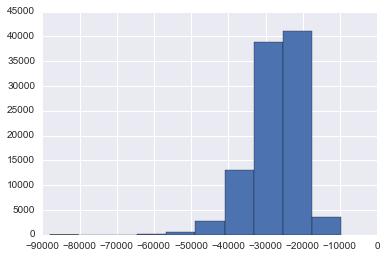

In [22]:
import random
import time

class MonkeyBot:
    def __init__(self, dfEnv):
        self.cash = 1000
        self.share = 0
        self.pv = 0
        self.pv_history_list = []
        self.env = dfEnv
        
    def trading_fee(self):
        self.cash = self.cash - 5

    def buy(self, stock_price):
        num_affordable = self.cash // stock_price
        self.cash = self.cash - stock_price * num_affordable
        self.share = self.share + num_affordable
        self.pv = stock_price * self.share
#         self.trading_fee()

    def sell(self, stock_price):
        self.cash = self.cash + stock_price * self.share
        self.pv = 0
        self.share = 0
#         self.trading_fee()

    def hold(self, stock_price):
        self.pv = stock_price * self.share

    def reset(self):
        self.cash = 1000
        self.share = 0
        self.pv = 0

    def make_decision(self, x):
        random_choice = random.randint(0, 2)

        if random_choice == 0:
            self.hold(x)
        elif random_choice == 1:
            self.buy(x)
        else:
            self.sell(x)

        return self.pv # for frame-wise operation

    def simulate(self, iters):
        for i in range(iters):
            self.env['Monkey PV'] = self.env['Trade Price'].apply(self.make_decision)
            self.pv_history_list.append(self.env.ix[-1, 'Monkey PV'] + self.cash)

#             for index, row in self.env.iterrows():
#                 self.make_decision(self.env.ix[index, 'Trade Price'])

#             self.pv_history_list.append(self.pv)
            self.reset()

monkey = MonkeyBot(data_train)

start_time = time.time()
iters = 100000

monkey.simulate(iters)
plt.hist(monkey.pv_history_list)

print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))
# def monkey_simulation(x, monkey):
#     random_choice = random.randint(0, 2)
#     if random_choice == 0:
#         monkey.hold()
#     elif random_choice == 1:
#         monkey.buy(x)
#     else:
#         monkey.sell(x)
        
#     return monkey.pv

# start_time = time.time()
# iters = 10000

# for i in range(iters):
#     data_train['Monkey PV'] = data_train['Trade Price'].apply(monkey_simulation, args=(monkey, ))
#     monkey.pv_history_list.append(data_train.ix[-1, 'Monkey PV'])

#     monkey.reset()

# print("{0} iterations took {1} seconds".format(iters, time.time() - start_time))

# print(monkey.pv_history_list)
# print(data_train['Test'].head())
# plt.hist(monkey.pv_history_list)


(array([  1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   5.00000000e+00,   9.00000000e+00,
          1.20000000e+01,   2.10000000e+01,   2.10000000e+01,
          2.80000000e+01,   3.70000000e+01,   5.00000000e+01,
          6.30000000e+01,   9.30000000e+01,   1.24000000e+02,
          1.79000000e+02,   2.67000000e+02,   3.50000000e+02,
          4.95000000e+02,   6.72000000e+02,   9.57000000e+02,
          1.37300000e+03,   1.81800000e+03,   2.42900000e+03,
          3.22000000e+03,   4.23700000e+03,   5.27500000e+03,
          6.42300000e+03,   7.88700000e+03,   9.10300000e+03,
          1.01450000e+04,   1.04280000e+04,   1.02210000e+04,
          9.02500000e+03,   6.93200000e+03,   4.40900000e+03,
          2.44600000e+03,   9.45000000e+02,   2.55000000e+02,
        

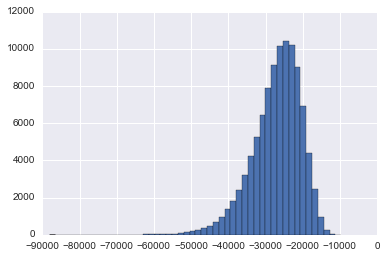

In [23]:
plt.hist(monkey.pv_history_list, bins=50)

In [24]:
statistics = pd.Series(monkey.pv_history_list)
statistics.describe()

count    100000.000000
mean     -27068.341619
std        6620.430466
min      -88045.366610
25%      -30771.395576
50%      -26144.459457
75%      -22343.499924
max       -9645.231109
dtype: float64

In [25]:
monkey_cv = MonkeyBot(data_cv)
monkey_test = MonkeyBot(data_test)

# print(data_cv)

monkey_cv.simulate(1000)
monkey_test.simulate(1000)

/Users/calvinku/anaconda/envs/udacity/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([   4.,   13.,   14.,   19.,   36.,   56.,   83.,  121.,  117.,
         102.,   83.,   90.,   69.,   77.,   40.,   34.,   16.,   17.,
           5.,    4.]),
 array([ 317.76278607,  332.11796378,  346.47314149,  360.8283192 ,
         375.18349691,  389.53867462,  403.89385233,  418.24903004,
         432.60420776,  446.95938547,  461.31456318,  475.66974089,
         490.0249186 ,  504.38009631,  518.73527402,  533.09045173,
         547.44562945,  561.80080716,  576.15598487,  590.51116258,
         604.86634029]),
 <a list of 20 Patch objects>)

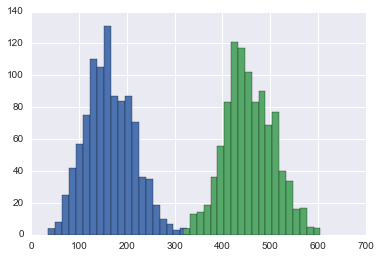

In [26]:
plt.hist(monkey_cv.pv_history_list, bins=20)
plt.hist(monkey_test.pv_history_list, bins=20)

In [ ]:
class ChimpBot(MonkeyBot):
    super(ChimpBot, self).__init__(dfEnv)  # sets self.env = env, state = None, next_waypoint = None, and a default color

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)
constant = 10
result = 0

def divide(x):
    global constant
    constant = x / constant
    print(constant)

dfTest['Result'] = dfTest['Test'].apply(divide)

print(dfTest['Result'].iloc[-1])

# temp = 10

# for index, row in dfTest.iterrows():
#     temp = dfTest.ix[index, 'Result'] / temp

# print(temp)
    

In [ ]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
print(dfTest)

In [31]:
dfTest = pd.DataFrame({'Test': [1, 2, 3, 4, 5]})
# print(dfTest)

# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

# print('===================')

# for i in dfTest.iterrows():
#     print(i)
    
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))
# print(next(dfTest.iterrows()))

iterDf = data_train.iterrows()
print(iterDf.next()[1][:-2])
# print(next(iterDf)[1])


-1d_Vol1         3.0
-2d_Vol1         1.0
-3d_Vol1         1.0
-4d_Vol1         1.0
-5d_Vol1         5.0
10d_Avg_Vol1     3.0
21d_Avg_Vol1     2.0
63d_Avg_Vol1     2.0
-1d_Vol2         1.0
-2d_Vol2         1.0
-3d_Vol2         1.0
-4d_Vol2         1.0
-5d_Vol2         2.0
-1d_Spread      -1.0
-2d_Spread      -1.0
-3d_Spread      -1.0
-4d_Spread       1.0
-5d_Spread       1.0
10d_Spread       1.0
21d_Spread       1.0
63d_Spread       1.0
-1d_upperwick    0.0
-2d_upperwick    0.0
-3d_upperwick    0.0
-4d_upperwick    0.0
-5d_upperwick    0.0
10d_upperwick    1.0
21d_upperwick    2.0
63d_upperwick    2.0
-1d_lowerwick    1.0
-2d_lowerwick    1.0
-3d_lowerwick    0.0
-4d_lowerwick    1.0
-5d_lowerwick    1.0
10d_lowerwick    1.0
21d_lowerwick    1.0
63d_lowerwick    2.0
Name: 1993-06-23 00:00:00, dtype: float64


In [36]:
lst = [1, 2, 3]
lst_iter = iter(lst)
type(lst_iter)

listiterator

In [ ]:
test = pd.DataFrame([(1, 2)])
print(test)
test2 = pd.DataFrame([(3, 4)])
test = test.append(test2, ignore_index=True)
print(test)

In [ ]:
print((list(test.columns)))
lst = list(test.columns)
print(lst.append(2))


count    5.000000e+02
mean     1.011342e+09
std      7.114917e+08
min      2.025580e+03
25%      4.599297e+08
50%      1.019479e+09
75%      1.525782e+09
max      3.528897e+09
dtype: float64

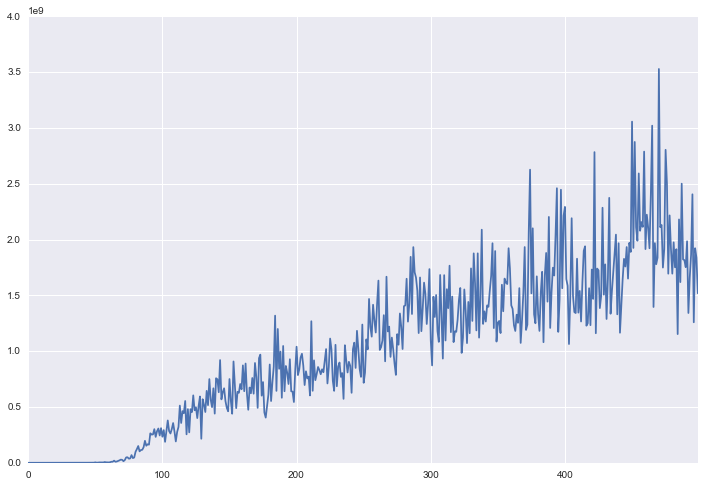

In [69]:
pv_history = [2918.3240283131045, 3821.8478066270945, 3939.4570934885824, 2397.8849674453004, 2025.5795376535978, 2734.712748770502, 3245.6111362200845, 3544.8380880789864, 3495.460270078708, 3184.8949370405003, 6967.133003109397, 10012.59117782851, 7814.5676240798075, 10182.684916160872, 11562.349863301706, 8904.540674257893, 16709.828063931185, 36281.94466495626, 14191.692212935082, 18584.026717630393, 41794.01670350159, 31747.51776805102, 65701.13139567738, 56712.0694771982, 63289.881251906685, 88776.9731022494, 80471.52966222573, 82536.0229780134, 84555.9622810239, 97015.41639561074, 150512.60677160101, 180489.08131018287, 64345.44138481978, 279007.0180593079, 174024.17358978683, 366612.5450674156, 172794.7370801902, 324173.2550623718, 349267.77752662875, 451839.7390839469, 517232.15893598396, 842187.2907668137, 781841.3211120815, 1129680.805816016, 813056.8921316891, 823356.7487409075, 724706.5493280089, 1270830.6028853252, 1275772.6422696696, 1371042.71140841, 4075175.121021984, 1382483.419295052, 1880191.2698873666, 3422733.391683606, 3454832.07418811, 3212798.5972811347, 3183686.088243327, 6922849.252691881, 4404295.988477954, 3853448.074873838, 3376880.65254872, 4979964.805485654, 9439463.86454712, 9292182.00509208, 19116529.60117084, 9323278.43855429, 11599596.616283657, 16724033.214657856, 21703894.185725395, 28489711.928347506, 26580023.582673717, 14473143.359343737, 24716815.0651162, 48415943.759251855, 49630394.18505422, 36918536.12942636, 39196328.21014502, 69032754.59900622, 42164349.29962269, 47239472.17614992, 98837062.77712938, 122833338.74517804, 150285851.98756668, 102555291.2494965, 114294006.03076735, 116489679.74444064, 139541894.82558075, 197192841.35831705, 152926351.99625984, 166202836.29359186, 162270629.57355937, 264003622.14947703, 252315086.89926752, 254625474.8341475, 301620560.399532, 232145645.2300491, 283230516.02529263, 307283384.1151039, 244941419.316295, 310500445.6884616, 233829278.00673497, 292903743.5945943, 187815752.03531522, 283907864.50067407, 379574061.4918533, 285174474.99742794, 262491644.27723065, 301813247.5653415, 356299958.35932475, 280968307.2624548, 191342706.17102665, 276670658.32956314, 321414163.36467916, 512743757.48175216, 356619284.48008996, 462982901.51170135, 444366088.413427, 554008711.2761095, 255168414.92648068, 481260960.0325318, 272489984.96641105, 480181096.89866316, 454351118.27192414, 604458604.2893044, 470602201.00892943, 497724195.9779744, 400543851.91315424, 508977674.92890877, 594369470.4320594, 215595465.72873092, 569795375.9885151, 519293707.0953488, 454929321.5509685, 644847300.8429013, 516564394.11269987, 750321296.5737603, 566778634.9459622, 498464223.2809894, 667744823.6810012, 440858219.99787784, 757705667.6484032, 748483716.6266935, 631966835.6436645, 920373286.7577796, 568259844.5168259, 633676909.2523541, 667692181.3173773, 553505611.9593544, 492205101.95657676, 461596485.377743, 750480778.2805732, 558561625.5518509, 439476264.8378738, 908033237.7155777, 689758083.7621083, 489542141.5500597, 636407329.7966211, 627426502.0906539, 706236997.3033471, 658670856.6206152, 872769834.6702908, 641643673.7274272, 889330690.9359896, 621458211.798627, 474965450.8152532, 674449748.8551067, 623291212.3806645, 760043504.9668972, 619067977.3671876, 894648354.4124603, 768450011.5422447, 492553960.2044871, 937569756.8541563, 969169575.058123, 601565034.1652402, 723599740.9183241, 450910847.98140365, 404945432.61731017, 511162962.4648428, 610875472.4085276, 880709399.9231112, 553579492.068077, 722945410.3185575, 861022188.3596317, 1318502183.0893388, 644554134.678687, 1199061001.0894341, 841909856.027756, 996388668.845702, 582916169.3807119, 1046682011.6159866, 641101114.0247974, 867869588.3327757, 808377543.4597101, 705883968.7222407, 927883592.800679, 640952426.722497, 637917031.0810654, 544444710.6504865, 829266218.7163377, 1040078545.7548954, 785879635.4687787, 836708217.8087791, 943714098.59008, 976936770.4982334, 871589634.2213377, 696608731.3605143, 819719635.7129223, 755700053.4385865, 772242586.5077364, 603587828.5125496, 1268400501.9526432, 645335106.7740569, 918208739.304267, 740297301.0450182, 795255511.782174, 858531449.644066, 831214454.2931466, 793569792.5921001, 837850746.6519824, 811464170.9537094, 914173540.2084113, 1019269289.3570485, 711017001.5176904, 856544950.4110609, 1113329186.9891922, 1015200499.7375307, 735476664.0158294, 644395462.0267524, 1057180605.7969981, 686225465.8558282, 862807570.0355955, 898562822.2138318, 769941893.9340129, 804198719.4558095, 573141207.7778177, 1053923946.8869942, 917121825.8331836, 809239003.4638209, 905011874.3045928, 869003812.7110808, 627366805.4840903, 1018527884.9758537, 1076511679.660876, 850198098.5271487, 1182936240.6757889, 1023628187.969584, 840808084.5728991, 769758947.8405265, 1238635198.343184, 716706938.5957055, 807774440.5700026, 1106218801.3089185, 1016620848.485281, 1467915663.1139307, 1217950306.4854274, 1130166804.9259007, 1416504503.4489665, 1275529403.0494359, 1167133703.4583952, 1425923978.5503323, 1632553674.4912775, 1011383320.9111432, 1036616485.8542805, 1096668156.413134, 1322773061.497304, 909449373.91151, 1667388689.6230428, 1177003719.1947114, 1220180667.7730646, 948971872.216284, 1122112376.68016, 1018612856.7282263, 889292705.3972101, 787406396.2858082, 1153138699.9162548, 1058021926.9376445, 1338172322.3285327, 1217704677.4906843, 1019689144.2736335, 1403296606.8296173, 1410038636.0888336, 1649108161.702126, 1265242549.9862552, 1427614128.8019588, 1845347519.8633528, 1333294657.4468334, 1932471319.6480052, 1707065119.8616858, 1659140142.3864582, 1541343007.8256636, 1162728287.6597855, 1660499124.4127264, 1179507291.7972054, 1382394253.064311, 1614603248.9290257, 1512785566.232301, 1243503584.574294, 1424742915.4475558, 1735547006.8484342, 1097510418.2425668, 872737267.0661304, 1488321544.8830042, 1306294189.3348, 1503341749.668855, 1180920542.8298714, 1083274802.373768, 1682730418.6241918, 1313796125.7076156, 933855854.0457194, 1681284561.4736323, 1096183446.9620829, 1555631292.5135355, 1385878396.0320673, 1766175158.4797103, 1170790422.521343, 1489328346.6143136, 1081438125.446831, 1178093665.934205, 1173251948.5373356, 1281124389.1219316, 1460664210.045802, 1566685048.3528466, 984926690.2019516, 1121727654.1708858, 1553165529.535788, 1363437994.3176017, 1072581499.4736441, 1441212683.1752582, 1161077918.2599807, 1741569786.6275465, 1271366482.6541078, 1876461027.4164608, 1607286815.3796604, 1186337873.1348548, 1876634532.6729722, 1121612734.2741919, 1481690714.8915305, 2088703806.8153656, 1244113924.3207421, 1357032632.8336225, 1265610079.8451288, 1410509242.461519, 1397682063.8191595, 1543586442.372682, 1675079995.685694, 1967300181.428839, 1207329457.3116438, 1897253523.2718713, 1086514239.6523316, 1255806656.9027307, 1271356809.0704226, 1162399801.445785, 1595549906.1147068, 1358025729.2109778, 1650563582.8035736, 1614693790.221244, 1601834530.764247, 1922550047.1280155, 1739963528.5446005, 1410940909.4655588, 1379102311.2047884, 1232034011.798452, 1181343625.9473007, 1327413566.2698376, 1254032106.2508128, 1565015012.9003994, 1074330584.9061356, 1276839550.5518034, 1523900036.4796894, 1933158662.7480168, 1190517138.8242276, 1238153522.8214653, 2058474420.8131125, 2626458751.806641, 1518505266.619411, 2101138991.6789596, 1330132830.07144, 1250162971.6541066, 1670561062.77915, 1331754387.2415175, 1181540633.1345315, 1524970200.721418, 1711051047.9765112, 1080770035.4586866, 1679707911.0109408, 1880207963.2085056, 1444017522.6894953, 2203088403.5525618, 1208474909.3591802, 1528216572.466036, 1748575306.7949524, 1677896117.7288191, 2041897414.2611072, 2460372565.684627, 1173259773.1800292, 1462777181.1501253, 2446799763.3822837, 1564452011.4794989, 2214724228.4000974, 2293186110.6201873, 1646321663.8870385, 1586223168.5649304, 1064296167.0629052, 1509038171.5562255, 2191436408.3004785, 1495496400.8521276, 1350463087.4114294, 1341988341.7905777, 1828666875.9674232, 1345726811.419256, 1539934980.1786137, 1266453518.9899683, 1615898183.6346595, 1899716842.6773295, 1940026264.926786, 1228528853.5330021, 1250807963.4390538, 1564226845.7044535, 1233327946.243268, 1731548705.8222215, 1468801241.7076614, 2783896202.9539523, 1161036363.3735344, 1740360219.9077556, 1724806291.001509, 1385943713.5922093, 1497150631.4159858, 2285487345.4883275, 1506216768.4101527, 1777697311.2125022, 1288839515.9518132, 1655044674.7783573, 2373875940.670575, 1335761553.598993, 1537729884.5217905, 1704350298.6493795, 1870128960.6441932, 2044511998.9358199, 1330376990.765517, 1967366347.7519557, 1165571858.3276885, 1411854606.1068645, 1645858058.504203, 1827709189.7099078, 1758750311.6526103, 1933485327.1393168, 1650598821.6547945, 1971046394.214556, 1889333825.1275496, 3056964627.3016825, 1925589592.5009286, 2874903068.5115128, 2109771969.9132185, 1989787401.6806505, 2592801577.4716578, 2079059191.5869818, 2157090847.498663, 2113787612.396843, 2788376656.3295565, 1915082174.5161037, 2223546489.3098574, 2107321789.8477025, 1922212768.4204586, 2401228868.5337577, 3020896893.8906045, 1396225311.0632277, 1968216571.7590592, 1779094695.4222872, 1837860443.5518234, 3528896541.9754515, 2111659721.9743009, 2130878481.8912995, 1749596773.1857233, 1914483513.4919894, 2804354048.367478, 2503429114.287205, 1694801054.7367048, 2216574723.7108793, 1916392857.1183255, 1695087993.7759109, 1975468403.6730828, 1751471919.9862514, 1913871235.5175636, 1153427181.5134637, 2180520331.7573795, 1619381082.290666, 2501066363.3146424, 1823115825.3069222, 1815967333.6818173, 1752920378.656846, 1984867947.6177144, 1342401342.0951984, 1659812156.5981946, 1864753977.3890777, 2405798194.433707, 1259270889.1130347, 1923005967.1950936, 1837809721.779897, 1519578423.055408]
pv_history_series = pd.Series(pv_history)
display(pv_history_series.describe())
pv_history_series.plot(figsize=(12, 8))


count    1.500000e+03
mean     3.529274e+09
std      1.888524e+09
min      1.615583e+03
25%      2.204779e+09
50%      3.811525e+09
75%      4.976336e+09
max      7.963347e+09
dtype: float64


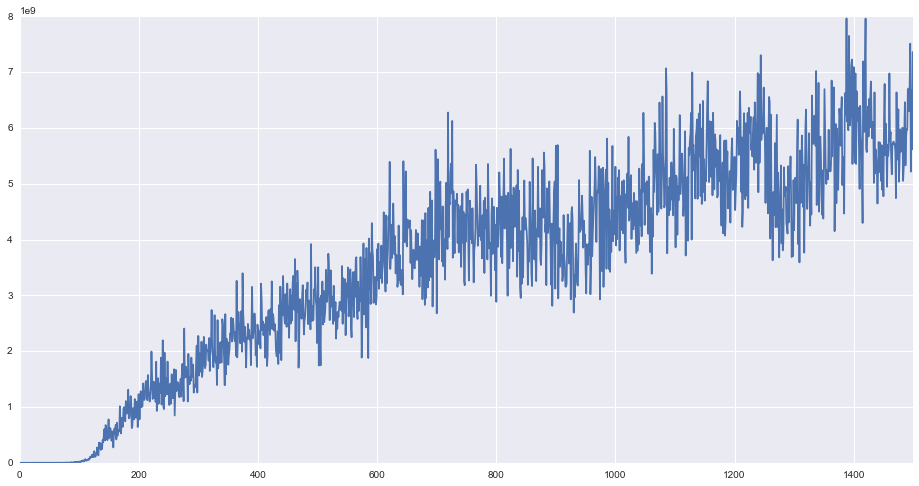

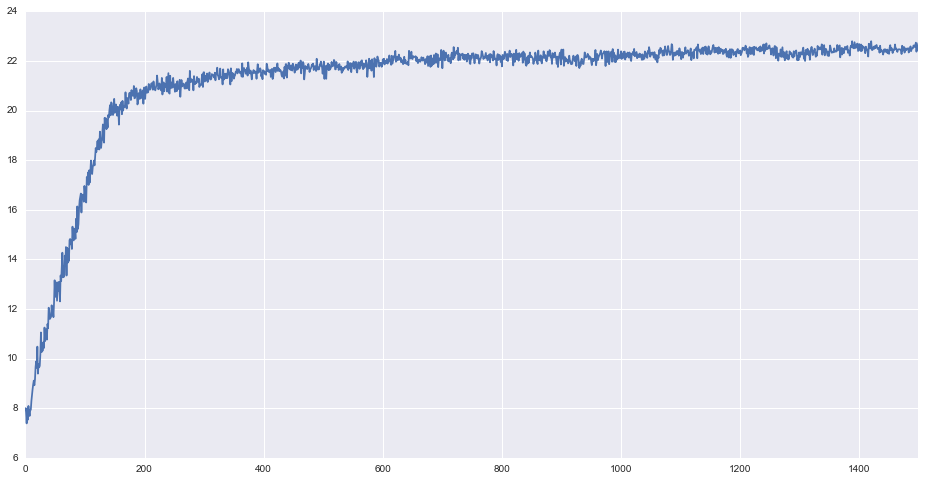

In [27]:
from __future__ import division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from IPython import display

pv_history = [2978.120850945398, 2589.0045877108014, 1615.583069851909, 2938.792709129515, 1874.1253859598987, 3266.9592995998064, 2590.028311998802, 2180.1522853510915, 2729.0403011814033, 2805.8384912876922, 3986.6811560918018, 5158.696484367892, 6416.166299250987, 7811.997053576994, 9055.640933033104, 7513.808492530399, 9466.303472431466, 15723.837826446206, 19681.69584575963, 15175.883356740487, 35672.96336205165, 12023.86485568976, 17504.62499274179, 15510.044167964094, 16433.31849840273, 26085.823099409157, 63129.17712529434, 28498.097888784356, 32276.77053433046, 30335.79717812308, 42509.90317753481, 33730.312561332576, 76962.89357298556, 44585.730224202045, 61471.377693057664, 71652.8819311667, 47373.45845235453, 88954.97538666248, 74976.28303155134, 171535.11395582312, 142127.24231765352, 109003.42292162239, 113406.13025365393, 118641.89167657336, 189142.8854454943, 127879.79738390371, 161465.89237735973, 117185.04497143498, 211742.80899389385, 517641.45200077, 264781.4085039208, 314538.55452818447, 473511.4999452486, 227459.04664602122, 321928.00198926294, 481963.5162552435, 336954.3014345333, 482518.49538509327, 221036.7462543341, 628099.7222338399, 503336.34476929985, 862128.3938778908, 1575967.1056552287, 583825.5454383368, 904985.4433364444, 598427.2939362051, 1400257.1940334076, 948684.7040817677, 1978869.0421268647, 627745.8449642435, 1924105.7871902178, 1052779.1535642562, 1841079.653434981, 1132620.9213592303, 2612484.969159391, 2741598.6456313934, 2202985.65651574, 2591762.852829812, 1832853.9229296288, 4499606.618423602, 2752378.2515647244, 2584328.1635664585, 4148589.5910951938, 3847501.3483654214, 2758051.3068197276, 6187939.139934411, 3608886.8863580883, 10167858.92055245, 4099296.070107225, 4996321.029684342, 9356203.628081186, 13021671.857980302, 15078148.03922328, 17111373.980669457, 7972945.420184139, 16423793.495305458, 15899415.257149791, 15933383.991044967, 12313151.497428814, 23267226.75547318, 17155759.329630073, 15068425.510415806, 11930430.59309687, 33323577.22017842, 26722450.871071573, 40026351.87017422, 24221352.081904717, 43656381.690116584, 26726653.746059448, 41395344.87452415, 64830792.171848305, 44868324.80709413, 37574474.598145224, 49679142.816460125, 54804848.98292741, 64610098.05144303, 53262459.2429713, 76041695.75104065, 107333019.2084112, 91074658.62367702, 109495849.8613294, 142402890.3854095, 101915096.81714143, 152540438.4265868, 101230024.56750734, 207568404.89669046, 124302292.91759303, 107676401.25036584, 141818216.1145358, 187640824.6050381, 277357290.92158437, 149209335.01165977, 133258900.54502635, 361758054.51596284, 272774248.865059, 356312173.34903246, 229296543.51158503, 328431973.4869832, 244615850.98647067, 407094761.5816893, 368037324.38865477, 492248624.7510704, 604738292.8870761, 400721528.32547295, 676682347.0457654, 647534696.9381701, 487382438.253443, 405560794.8142263, 504904966.4200774, 777888376.2057035, 442465053.7305104, 549339795.8870571, 622069887.3695307, 527307870.8452844, 394326037.3595601, 565456026.5273459, 477546904.07641745, 275874455.62681156, 557606177.9833201, 616663707.3594108, 508073939.49938464, 680071430.8536443, 419533109.9028891, 717105269.2237291, 484122857.22192264, 589761455.8141974, 571701935.6211358, 561918815.2103403, 1013906335.9277126, 626921783.83985, 526617875.9971462, 806438479.9011261, 708823650.8576399, 642673845.2843423, 964706822.2152961, 996968478.6444465, 983286085.4534551, 742365883.476478, 1107287823.0744505, 947643975.6495212, 883125348.8186548, 891916988.241553, 1310437897.3162322, 797291643.9223626, 808033272.3426188, 948203805.4943372, 1196347307.8210094, 1068728603.8124596, 621659443.5135628, 666512759.2658839, 980384118.3777306, 887236692.9129449, 777234301.410423, 1142361844.4653563, 911985283.0242794, 805825913.6530608, 943661103.7628247, 1097765448.9033403, 641076919.7845787, 1224275650.4304574, 1227275313.878174, 777591672.4027503, 1159777337.5308945, 1283789872.987535, 995727863.2503663, 1011981529.5736747, 1013321190.7505966, 1421531039.5785944, 1154452958.2008371, 1126250226.6430793, 1162905001.3234491, 1423981622.317355, 1467492099.6788259, 1341294921.4647422, 1123328481.4779344, 1573256461.3905752, 1278284012.1281114, 1213246993.7669077, 1097166411.9148026, 1217094014.4623027, 1376466711.1924458, 1993840602.429219, 1553372495.3035228, 1144143547.8935704, 1198549165.4682105, 1452592535.214989, 1168643625.6171772, 1242293764.88163, 1092745111.456727, 1810991328.4553266, 928935821.3428543, 1222228752.340389, 1515477363.4032226, 1057477710.7520121, 1317941369.3773336, 1422601736.4237194, 1253319817.7134953, 1883620596.5528843, 1045828852.4425887, 1490810834.8287897, 2196057915.423447, 1004855529.1837326, 961601821.1775062, 1974505816.2338843, 1191527293.279349, 1356685429.2384965, 1518915260.2144125, 1225869159.6926053, 1813748571.0536964, 1368161308.2836576, 1380446872.135529, 1035519462.9631246, 1405578280.342818, 1422185516.0588765, 1059560226.0355206, 1585650194.2324154, 1158546865.4203727, 1287514019.3913572, 1164125151.2572765, 1676607669.360198, 847648875.0067916, 1234187133.9935067, 1665086715.5617347, 1285904786.229615, 1326789357.5781033, 1445239807.2929282, 1422278649.7614048, 1190632218.8997738, 1175537886.496062, 1373772496.6846004, 1504982484.0514464, 1186031341.846214, 1592353145.236303, 1772727819.89769, 1497502147.097672, 1105244699.0603132, 2405718249.1326766, 1528431832.561737, 1683213990.8264434, 1722183938.9000814, 1530950269.2334893, 1657816655.788481, 1098649271.53364, 1951056343.8160074, 1506657740.4855192, 1408574544.2322083, 1539267452.247047, 1467090663.2323282, 1885350911.93728, 1616972066.12055, 1534342347.3232102, 1760414075.6878362, 1257273481.4161432, 1368167078.0832083, 1385698449.2953353, 1359507598.3722973, 1805390458.9010196, 2099452127.7352738, 1258586265.3662941, 2271646779.8417935, 2268632644.6097236, 1564751001.3756275, 1958970703.217059, 1950676036.4262147, 1630386700.622301, 2169418146.7205725, 1537737181.9560199, 1653009504.0523725, 1919444628.2731328, 2256392565.5919, 1767309163.9495804, 1695208155.6791515, 1748133491.9392974, 2119497487.527298, 1997217064.6717677, 2014521137.4189465, 2021124758.1298563, 1830864640.8215857, 2237374016.12404, 1645947120.1888971, 2158744298.8485208, 2124212849.7207065, 2738701640.6849847, 2010777879.0110922, 1922210849.820766, 1712939179.973091, 1951686224.5181963, 2645727965.580346, 1853420724.430088, 1794032955.0574393, 1891652137.0931964, 1393545549.931697, 2556397030.9868436, 1692849885.1050925, 2020824278.392588, 2138027615.755584, 1787881211.5237107, 2162945145.271782, 1812841575.8255892, 1797668031.1528752, 2573253452.0792665, 2471586701.0492387, 2198155332.7395225, 1839287709.769806, 1389760446.0425873, 2664676572.4843, 1584429344.061923, 2226721628.405509, 2056873511.326467, 2160756203.3234367, 1757277620.4969165, 1934344822.4383016, 2026941919.4773066, 2315485045.038964, 2310326064.584887, 2600875341.790943, 2173516427.470107, 2499371591.095701, 2583210646.332255, 2424638816.1951733, 2223165846.218805, 2179187831.7280483, 2344234864.966371, 1914352157.105978, 3260209590.883808, 1889343618.2078848, 2196739781.57973, 2703162267.3822494, 2473808148.257627, 2491673261.084885, 2143555596.0433767, 2292265802.1217217, 2720012055.5714197, 1991398128.8816104, 3397284978.069829, 2696125591.8633447, 2405923098.8629856, 2169181922.037109, 2436578014.1337147, 2104131662.812015, 1709271869.9074483, 2244325859.2653465, 2214063905.54494, 2487961914.1944532, 2226666932.93135, 2388283546.3589025, 2205024263.7521114, 2268773087.8900566, 1750556333.5707746, 2505065021.8541117, 3152627296.645988, 2231516784.158172, 2300164616.588891, 2445910873.0754824, 2676586575.9795713, 2531526319.253654, 1926187607.8748815, 2167483046.439447, 1720058725.1277382, 2476898705.149464, 2335187282.6933265, 2370110287.5302887, 2121628599.8088036, 2320595197.043307, 2051476250.5123112, 3210573169.5103683, 2917676502.8944316, 2375159057.1973505, 2532353958.5101113, 2288520849.491104, 2387495390.9068637, 2481258856.822402, 1882978258.8268032, 2492043549.962855, 2612498948.8732524, 1734290827.3488805, 1915700377.678468, 2714913052.989506, 2736420153.6604958, 2517927921.9092255, 2292185702.5621657, 2753013997.3807645, 2440664863.1991043, 3251780034.558778, 2393841220.29687, 2667433449.274303, 2586811826.6109443, 2367973200.786166, 2485335041.636698, 2377513616.0796456, 2027392616.1000514, 1910218746.5387568, 1907346948.7301598, 2355459963.8895636, 1770090117.5585566, 2824030614.398804, 1971420335.519686, 3158526640.735654, 3146088031.11699, 1839895143.5258703, 2875107304.9973445, 2644987267.1390414, 3348422469.7227273, 2835937868.5335736, 2621408768.490837, 2496528425.0854425, 3021874577.4747224, 2546375522.7019587, 2436477489.9620786, 3213677255.3284283, 2858324747.410809, 2694072965.818768, 2240804323.7468424, 2690144634.772189, 3111570464.395768, 2497290584.0086083, 2995567940.160317, 2549778063.709477, 3208050957.8746347, 3348568167.763783, 2796734002.4010797, 2743617952.0658693, 3651037848.5241895, 2177664666.265986, 3215605135.918843, 2699050305.0867915, 3443656631.996666, 3191508819.181716, 1705686522.684711, 2166924018.3473406, 2933143343.3565145, 2689662580.299579, 2827885323.057951, 2582472845.556307, 2989302968.612532, 3183921762.298791, 2825559376.1152763, 2299448961.9646707, 2542607858.3522544, 2626916693.973569, 2807016050.731473, 3103781274.637845, 2923793053.5488777, 3231783109.868883, 2486052145.1800876, 2806353170.9614897, 2907969978.535845, 2742625739.2310004, 2390927797.994823, 3919968105.239589, 2540231761.5188446, 2804928806.798789, 2549405798.9422755, 2565354047.977463, 3109851715.59284, 2999414729.801244, 3504564780.504738, 2895934591.1021056, 2812670813.5152555, 2146362102.3542957, 2997828430.448571, 3505072661.283978, 1743966035.7862787, 2944216768.7591705, 2204042018.753384, 1746703333.7160676, 2997567124.777705, 2651660598.2523127, 3248763425.4700303, 2478444786.6660547, 3082641951.432283, 2520275454.943651, 2626119563.29228, 2769454876.048935, 3457644800.220056, 2950109853.8500743, 2884339681.267514, 3142138806.3531394, 3745902579.9829674, 3540043228.355594, 2557909792.3671546, 2566766125.6317887, 3448641521.3115954, 2953411904.3179765, 2796014656.6557302, 2977247849.748264, 2489511285.0901046, 3172398361.9096403, 2619144771.842283, 2544902736.1399345, 2881114642.349265, 2225430137.7258496, 2690605857.231068, 2401578516.745371, 2706207841.4725714, 2613835891.262635, 2771836802.47369, 2881555079.2031264, 2752732690.6493483, 2887452892.1796174, 2727143789.8948736, 3526364850.654537, 2490311074.2722235, 3308847278.4106393, 2685667110.3187647, 2843078206.148986, 3291092837.047131, 2286947723.6285367, 2847639267.1804748, 3218316063.745887, 2978872583.1020975, 3499661991.517417, 2624045461.9333553, 2831999648.2063017, 3390465565.2749434, 3467756653.766943, 2455260671.5020137, 2250265411.3269787, 3084280580.92821, 3416133285.999003, 3294003884.7605476, 2611699073.4456096, 3423160419.749321, 2974221700.7833896, 3634968050.0924716, 3684493745.6618953, 2737426871.128788, 2576775365.492732, 3244019740.424362, 2719226219.810915, 2911708897.3817344, 2903392472.6150994, 3687124990.9722643, 3211554540.513891, 1885689851.7998855, 2555475241.7136216, 3063131912.1232176, 3931520750.524622, 2660500181.7319894, 3150436357.0093174, 3656977539.27272, 2426794958.878705, 3850382620.0852785, 3097530413.569601, 2967575409.756403, 1877819434.0440574, 4018796263.818749, 3112583449.455238, 3756918524.8521843, 2846273143.4183526, 3219361740.7122884, 4294761475.003534, 3821500201.269205, 3683805296.87457, 2865662512.1689854, 3086824824.358123, 3333604529.2340255, 3306195357.821707, 2839504081.619291, 2968737864.0635576, 3829227865.886339, 3271494892.1929564, 3928466602.313402, 3117269023.1421394, 3592939889.1358275, 3568980797.76903, 3307083259.8107085, 3892604186.597069, 3222850105.2636285, 3636028148.194275, 3648014264.0756884, 4488883299.413533, 3551305517.6179223, 3392348068.0924816, 3068828183.756311, 4434097562.589391, 3215445181.167498, 3580242159.8588753, 3781983213.494984, 4415445273.831031, 4243692254.054504, 5392344471.678211, 3473455686.5631647, 3750912631.730071, 4263614175.703706, 3669913059.1002116, 4208425211.2377734, 4645997583.760537, 4081250100.5702405, 3735084582.853569, 4061069061.1320624, 3393570283.0407295, 3728965941.785772, 3694543841.4766483, 3152579240.117116, 3267149422.3630595, 4252395446.0477247, 3278176570.067089, 3722132853.241219, 3218693976.877368, 3186505897.236522, 3187402999.380916, 3461978823.9086976, 3018209335.7126245, 5404214869.785477, 4255713276.208592, 3955889639.3071613, 4402813335.67353, 5221667797.050235, 3945914758.730762, 3876783141.4818044, 4360401042.230115, 4211463006.198284, 4240989804.0973687, 4259339811.7333317, 4344091328.729248, 3583664216.533975, 4170136466.2349334, 3580816591.704323, 3290356168.2713614, 3688669424.5493174, 3819100271.528908, 3519392792.4391074, 3483126362.937593, 3693823477.2138777, 4172798431.62298, 3737384784.387383, 3633132077.306669, 4111605789.9404697, 3787024000.4847507, 3645472811.0627465, 3153984273.4553156, 3878078449.4293823, 3348068692.738881, 3581265306.186384, 4348174973.5055, 2931886036.164913, 3565171263.7341566, 4343020027.649394, 3999390804.7176905, 2829777025.369303, 4475978319.494112, 2953745549.2530675, 3552268566.916641, 3989731907.8143945, 3142364857.939245, 4568233050.68205, 3270171759.3741107, 3709685369.2006288, 4858058371.9105835, 3769406372.2305527, 3323710910.3742986, 4701360578.147363, 2801409245.2576137, 3848172952.921685, 3984643933.3314843, 3681280079.044978, 3883738180.0396047, 5610956173.983186, 4849980693.4877615, 2678325055.032199, 4348972589.667859, 5440764467.081485, 4534465468.911154, 3645338638.928844, 4826491378.285075, 5039174637.178706, 4192752682.756379, 4258434840.289082, 3609179295.8885, 4595105004.309958, 3522961252.4896674, 3967226727.1205482, 4004468476.4807873, 3282023603.521833, 4621087916.483483, 5019555755.666473, 4543584170.039752, 3831039454.972409, 6277174723.762917, 4044852121.225185, 4671830123.139556, 4632021926.513421, 5202691613.771147, 5360506680.161506, 4829557014.327285, 6126154589.570018, 3675271512.853434, 4865639473.464035, 4249838296.2239056, 3757683072.7770176, 4702830731.994105, 4636841355.195638, 4624324564.2517395, 4821134853.394335, 3941102853.0081816, 4624471262.810704, 3769104576.465129, 4529491906.848101, 3974370117.272045, 4598715743.988594, 3510222823.666344, 4286531685.153093, 4825771167.317956, 3944443877.237455, 4496311428.151561, 3253796654.125182, 3182280781.0552573, 4446779963.991002, 3963475289.9304256, 4857184649.664549, 4553815399.508839, 4899301074.895724, 3963601586.773608, 3266630767.420274, 4129074399.6294694, 4698030907.895283, 4008451559.4391437, 4551695573.712662, 3936782165.194642, 4560979278.466278, 4007217980.913457, 3233435279.082134, 3806468661.722678, 3914981588.2728376, 4206965768.4110126, 5341212799.478565, 4975453837.468916, 4463174603.727359, 3888897035.7227736, 4165377086.2297497, 4057793706.167751, 4528977258.221403, 4966332873.251946, 3994262155.705217, 4345079736.001518, 3664696721.3351626, 4437750917.773028, 3866572981.0416594, 4693785876.250622, 3401530282.279015, 4748530958.793107, 4213689865.176485, 4529470021.14573, 4191439536.3054557, 3644674741.4518747, 5354849565.682683, 4685354317.965271, 3841619230.0387936, 3948729225.465469, 3820514062.8759413, 2993659512.6930914, 4464311256.048768, 4738874290.24087, 3743155618.342264, 3861138097.532618, 4586133492.383653, 4092080263.3497763, 3451182663.5743966, 4262553196.7945065, 2886443322.696686, 4569817746.024245, 4474950279.955271, 3870941660.6400466, 4468288585.257625, 5204270434.514756, 4795688092.660345, 4161469405.5554533, 3691059011.3013287, 4769486528.450025, 3578103943.610624, 4384882260.744747, 4821953448.221815, 5451208858.81273, 4198724236.125627, 4750231498.236522, 4788364902.846731, 4653144486.675838, 3909378363.1261954, 2994462853.0711017, 4838512211.333481, 3488583905.765259, 3488544465.950672, 4401248835.821996, 5625108697.835692, 3851337390.4435177, 4789860059.131647, 4728901601.386598, 3612974470.3191185, 4932974799.212209, 4527490899.076108, 4228767188.4591312, 4490979983.068408, 4825754546.509579, 4973270022.962669, 3335821993.9628215, 5247920085.593027, 3795959309.5751534, 4878242976.827975, 3815552963.040333, 3139000072.2752934, 2955304326.952823, 4156149311.030339, 3211317229.178181, 4401176040.621584, 3322959115.8697968, 4344057053.884082, 5059607967.517364, 4182550737.282435, 4391972184.707659, 4268364811.9522376, 4146791748.931035, 3926735414.076909, 3189234687.922862, 3805537106.128095, 3607213710.844698, 5034262072.049445, 4567618911.796153, 4039788094.5455494, 3375913795.422961, 3167391886.5424805, 5455101349.8450365, 3708606208.6975884, 3827696168.9313755, 3644364489.7124295, 4522485139.019033, 3611348126.904172, 3256537395.3162837, 4184459078.4907055, 4062294163.1472626, 5304040221.641692, 4352266147.455472, 4043917290.9111166, 4559145022.191999, 3647865373.2979918, 3544362047.176596, 3925466694.3534694, 5245892321.261464, 4622872144.157832, 4394215177.080629, 5559931307.429348, 5303534955.047536, 4135809233.5158277, 4270279923.1430683, 3184044484.21704, 4917690862.902254, 4759460326.145176, 4121027688.7151737, 4572303060.659785, 5042503584.021214, 4310983333.385231, 3965865958.421309, 3190946874.0710387, 4284149642.480365, 2813465171.2626734, 3818566694.345023, 4356467600.197597, 4858696878.670046, 5041649665.529842, 3119554287.9083323, 5681171267.070121, 4209087131.593753, 3930923109.2971716, 5693643513.969475, 2946195707.2456727, 3742399318.2961245, 4202630029.524335, 3514324114.7808075, 3966281941.7423186, 3676426696.2319593, 3724605428.00057, 3257897527.048752, 3363140711.4083886, 4438983520.425256, 3706609394.275191, 3561594515.1017985, 3163177119.105308, 3154508915.143987, 3202820821.5874486, 3945508817.211557, 4449263167.101336, 4103601922.813507, 3572500128.996427, 3575411328.478615, 4297095827.98273, 2928128370.39131, 4456432689.427256, 4584159060.739043, 4367260028.163743, 3457586671.3849716, 2692999062.1722717, 3369015300.999768, 2967957910.307259, 3655206709.553364, 3927401388.515455, 3283745683.361357, 3190316338.183868, 3176505415.4035187, 3909238491.567847, 5065977199.747943, 4134899917.431922, 4160533297.3772473, 4172113855.402673, 4482709374.173774, 4786887476.43463, 4403609184.233527, 3856527113.761172, 4339194364.4159975, 4019957761.0086417, 4089443573.814887, 3428101224.649761, 3035252700.8572617, 3916435967.36864, 3904688379.6714416, 3551975135.216711, 3915627029.354979, 3720867854.385352, 5591857014.428451, 3022858677.824608, 3551402828.849783, 4765556954.541735, 3702113453.1985087, 4105205425.211377, 4395349946.56058, 4621646401.43883, 4951271136.006248, 5478914106.448715, 5005968295.717456, 3958025883.9337444, 4802762940.739556, 4856727620.3895, 4912852564.229645, 5314874379.648275, 4594887425.010701, 2929750766.6309276, 5216680453.6918955, 5267134333.653272, 3437130818.561371, 4268823143.6518483, 5287770572.046233, 3152580208.128569, 3936119910.000472, 4790879965.606991, 5006512555.107543, 5254541089.703056, 3477208815.379331, 5810070322.191122, 4208984139.7205353, 5014679104.143975, 3471370767.041907, 4540789759.82783, 3421867100.154834, 4327702819.968909, 3781088337.48292, 4446116542.115131, 5678114397.167361, 3972269582.473476, 4279967672.1160846, 4520226292.096328, 4096774862.502534, 5305926352.140005, 3895157657.2941236, 4767191127.420533, 4009027292.967994, 5107977355.407505, 4994860952.659453, 5244921513.089709, 3805113876.7620683, 4779519152.0059, 4166407010.4557533, 4502689729.486248, 5042033254.404832, 4649824637.180134, 4112584438.7576923, 5063875735.193974, 4815061405.179813, 3906921380.7429595, 3584196038.588783, 4813773491.848255, 4714677097.652673, 5183499318.802092, 4569017190.918041, 5841026627.317144, 4339543042.716976, 4421578698.799025, 4995296141.004146, 5155337766.7511635, 4012765346.344824, 4654239430.556782, 4453627332.681699, 4185044187.403197, 4837055309.144289, 4255222096.095739, 4692400646.279624, 4259405705.479679, 3759967590.3550134, 4689037409.161361, 3798213895.551657, 4352285298.049656, 3913281957.992429, 5271530328.828979, 4711730235.069855, 4251595874.1002793, 4892228649.709645, 4059257194.6181, 5355638213.987234, 4856805350.157566, 6271516032.258267, 5503404978.03885, 4263604583.3559084, 4785501597.536143, 5012176393.784781, 4629853725.014708, 5046597252.827233, 4831309613.510031, 4104414727.6397476, 5129008316.08064, 4519652790.585259, 3777846671.5765443, 4545778448.347309, 4566481037.866236, 3389259213.2934194, 4429180582.19954, 4053157549.9987607, 5607712621.011791, 4853785918.422916, 6091704243.785622, 5913220640.433841, 5269784628.693671, 5027179590.708196, 4444129985.669822, 5531211137.05504, 4497868815.315679, 4648942925.371847, 6456061027.085388, 5568749586.668235, 5447331477.294271, 4556158470.164462, 5132995595.8444605, 6565417511.049211, 5493363339.548152, 5276249821.495252, 4576638744.384886, 4623086049.754472, 5336604914.342566, 7068829997.961773, 6635001303.4937315, 3754164325.8195953, 4946492515.416328, 4662139820.270382, 4438836914.220997, 5106030607.444625, 4529991921.285549, 4880199936.137243, 5383386189.433084, 4717298907.273433, 5304479237.706828, 4434506317.555099, 5984227701.951848, 5256257259.777445, 4935640706.705134, 3860149233.4980345, 5146514487.079988, 5090657296.035887, 4088722913.102557, 4952304708.250503, 4703381154.683219, 5054979614.848686, 6230918801.685756, 4816800333.885979, 5149462621.213597, 5151246195.62596, 5541973563.1722975, 4981768649.874586, 4424236290.423309, 4646940874.000705, 5346210240.018794, 5941059955.774494, 3715052355.1271324, 4770904941.491357, 5073605194.743588, 5118724996.917642, 3980902761.8582993, 5638569978.698173, 5520451975.366649, 5773923134.727, 5899692539.62699, 6271348365.552209, 4000391719.2289033, 6995351357.913878, 5636351919.290437, 5698997483.384353, 5234799392.789916, 5505718869.952011, 4737868594.163292, 5851962469.503413, 5939473782.578606, 6154125989.509119, 4731129998.1003, 5416979059.901681, 6260252201.1610775, 5491683428.998347, 6424534399.645286, 4781947793.066051, 5991239920.308199, 4638229620.832047, 5063784402.203632, 6485152773.92597, 4855130637.444185, 5437594542.300641, 4698235026.967216, 5225996224.863493, 5044228956.067681, 5697557455.73256, 6363971637.918787, 6838535658.250025, 5971722847.49247, 5031863497.483861, 6121322975.653366, 5297732158.720308, 5125908867.631648, 6112046357.819481, 5991158925.46145, 4794226407.589727, 6272656238.381531, 5481244631.771726, 4901744312.388865, 5886955013.905897, 5775016963.682368, 5304238346.488888, 5614941750.742557, 4755337539.209127, 4797343123.517156, 5594748970.927233, 5048547131.250714, 5340494247.513401, 5872231001.838196, 4554158860.588767, 4251409869.020558, 4646948649.898762, 5382088848.1599455, 4112157070.0372534, 5114043888.70862, 5775644331.021138, 4071438338.367538, 4357832127.326139, 5776779596.257707, 5245986076.115014, 5578701431.456072, 4560314356.336902, 5010156469.125296, 4943954623.608842, 5226725966.584629, 4304495623.420197, 5149491623.689545, 5605568901.263576, 5815421484.496565, 4889137841.013671, 4929789740.286099, 4908221739.595333, 5483088066.060532, 4529330420.428177, 4870203534.786223, 5176165593.237924, 6127494543.095228, 5784093590.240864, 6008435356.606349, 5517163343.075609, 5785919912.172384, 6655765918.395166, 6270624697.059372, 4857759512.828586, 5830835752.562743, 4227848931.474031, 4504055039.362755, 5780568813.30017, 6265558917.786325, 4854547266.8523035, 4723263630.999952, 6086551537.935186, 5119519594.829012, 4783550719.389897, 6269392178.108248, 4567250330.985633, 6361247003.8084, 5908235429.543221, 5993442136.138124, 6200846285.040126, 5608098589.659056, 5738787140.287367, 5489381389.296483, 5903925051.939829, 6193454611.872191, 5254237684.310519, 6458821401.018809, 5846266777.4684305, 5375587121.617742, 5928727426.58322, 6191260822.555169, 6985204522.800613, 4848600286.736592, 6954978857.626468, 5378063464.748851, 6100684122.311222, 7304840712.9716835, 5785530828.86037, 6024414183.939033, 5902553466.621737, 6306719252.468118, 6725734859.828701, 6014238770.315957, 5763129569.657284, 4657355278.924826, 5635605003.367201, 6004866205.599048, 5597944075.415329, 4470985108.709027, 5879038346.510925, 6557208141.51197, 6468980276.4270525, 4019225548.8175364, 6239667365.037454, 4765806307.415069, 4516868850.718495, 3629736158.866343, 4851680419.265785, 4529328616.104163, 4436469455.179034, 5728638044.965646, 4221861465.46178, 5175047444.616462, 6236086631.611533, 4225991472.725142, 5200362511.809192, 4399387414.916267, 3682317103.1543627, 4607635812.857947, 4985312857.442879, 5328318272.972935, 3933071075.889692, 4539966224.788227, 3807496624.9749136, 3979346295.5212765, 5295703732.25713, 4776616467.929036, 4837441009.008525, 4946431368.751413, 4287794369.810943, 4221464796.131581, 4107669529.6749697, 5315674124.365317, 4307657588.684062, 5213573322.874611, 5094718810.492423, 5489922389.50687, 4739765261.847479, 3687538127.586774, 4318750591.7225685, 3702515456.8515882, 5065267098.860061, 4168124348.0209756, 5005625873.427923, 5108695302.020524, 4678783121.570138, 4652646035.479162, 5580199455.730877, 6150957696.731605, 3918772274.222126, 4837162574.177523, 3592163882.786382, 5597442216.378669, 4658033715.62986, 4671616591.378138, 5865872311.99951, 5448534922.005226, 4586225515.892967, 5342795294.7675905, 3766545647.824065, 4822985700.083187, 6006353515.468029, 6330444908.502125, 5474197842.204964, 4548920511.267931, 5302953049.286571, 5081514243.844031, 5905434554.500101, 4772076818.6178665, 4250753715.0255647, 5036247066.15882, 4449304135.65172, 6582662124.888037, 5968070319.136916, 5715927880.508628, 5757556553.373499, 6220756042.776266, 6062717545.6696205, 5683533650.964379, 7020837865.898408, 4619753314.412162, 6219189389.801055, 5246405844.752702, 6807461271.740275, 4500869522.556148, 5568637120.034159, 5845978022.286629, 5531522527.696609, 4821782938.638238, 4445012327.953742, 5240135823.903145, 4377570941.529703, 5250740100.01435, 6696390287.8252945, 6039365892.041288, 5315001506.912526, 4996845093.694642, 5164913504.8279705, 5252180407.743755, 5081958129.901109, 5969360709.628946, 5230909062.99539, 5387215719.679139, 5222260442.103863, 5346255013.568714, 6850240536.369199, 5491300093.719612, 6336284835.538471, 6402798465.898457, 6727042739.348035, 4152047642.9267135, 5364985756.711974, 6071439548.327686, 4653935825.915524, 5989454066.84516, 5232509686.641235, 4892349937.975202, 5660711136.670136, 6343991982.35797, 6190725857.32065, 5683347718.75414, 6300521459.959094, 6556260269.167996, 4978980622.280069, 5486198563.38302, 5332721082.6291895, 4466723055.481632, 6138189082.068893, 6630081930.955665, 6240671736.753999, 7963347479.3800125, 6114772057.729016, 6687060927.570764, 5961492427.800178, 7649826247.801712, 6728402742.607311, 6050163007.671572, 6330732347.252808, 7110201673.021613, 7225987191.676884, 5355940096.81673, 6238197171.235967, 7092320683.371905, 6028362961.4855585, 5379270409.513316, 6978212013.740349, 5354860153.272189, 6657510958.87933, 6130250374.005579, 6369656087.226979, 6230587546.815902, 5614760647.187543, 4909035356.217964, 6396293215.33086, 5868731126.139081, 5668834316.019108, 5227822135.260884, 4297646124.256771, 7192692603.956979, 6419762701.258801, 5931462612.641613, 7121419002.23921, 7961187693.281156, 5633371160.868322, 5568447337.900745, 5916102132.013405, 6384333567.969382, 5848006162.886752, 6521281661.138317, 6009884290.282424, 6581732124.817535, 6832942168.359822, 6178719642.486019, 5816612140.605244, 6107063442.860468, 6066209545.476541, 5015932072.1237, 6638373112.809871, 5185603882.623078, 5613800882.432697, 5453115495.720401, 5274618772.054327, 4646610946.389765, 5302577655.510117, 5749626497.419732, 5212325801.578665, 5737900313.494867, 5339663158.947102, 5052438312.722904, 5692254680.608046, 4891691663.956618, 5456660772.970837, 4776432513.338486, 6183936394.836782, 6789033375.023642, 5511984499.931469, 6077074409.81692, 5692826139.466222, 4946789378.791047, 5697415300.672081, 5500677794.20613, 5648294155.443063, 6978563640.953713, 5767814933.575579, 5929829408.285106, 5470375180.935477, 5170632039.812254, 5707990411.375954, 5726796885.453136, 5757305926.847592, 5704446978.256086, 5716844849.270729, 5580667149.974635, 4743550039.131296, 6638115780.778849, 5432322097.398802, 5626124876.490483, 6334193117.639764, 5037803183.382868, 5381913072.422237, 5976463979.106977, 5573403097.759089, 5869297764.243526, 5848628517.574791, 6004776109.328808, 5053172116.226661, 5283099219.6560335, 5842950562.330414, 6461604237.839547, 5330994493.905834, 5840994972.27874, 5974312367.280455, 5972867192.026882, 6684448219.203686, 6706815462.898704, 6301787549.851594, 6753285478.482748, 7511103242.111818, 5217156938.8053, 6681076462.172868, 5616457421.310908, 7360597041.404743]
pv_history_series = pd.Series(pv_history)
pv_history_log = np.log(pv_history_series)
print(pv_history_series.describe())
pv_history_series.plot(figsize=(16, 8))
plt.show()
pv_history_log.plot(figsize=(16, 8))
plt.show()
